In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import os
import time
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import math
from sklearn.linear_model import LinearRegression
import figurefirst as fifi
sys.path.append('../utils_2')
import figure_functions as ff
from pybounds import SlidingEmpiricalObservabilityMatrix, SlidingFisherObservability, colorline
sys.path.append('../model')
from drone_model_with_PWM import DroneSimulator
from drone_model_with_PWM import DroneModel
from drone_model_with_PWM import DroneParameters
sys.path.append('../EKF')
from ekf import ekf as EKF
# import ukf_sqrt.ukf_sqrt as ukf_sqrt
from scipy.optimize import minimize
# from scipy.integrate import cummulative_trapezoid as cumtrapz
sys.path.append('../trajectories')
from trajectory_gen import TrajectoryGenerator
import figurefirst as fifi
from IPython.display import display,SVG
import sympy as sp
import matplotlib.patches as patches

/home/jaden/.local/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/jaden/.local/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


In [2]:
sys.path.append('../model')
import drone_config
FLAG = drone_config.FLAG
# drone_config.FLAG = '2'

# from drone_model_with_PWM import DroneSimulator
# from drone_model_with_PWM import DroneModel
# from drone_model_with_PWM import DroneParameters


# set the parameters for your system

In [3]:
g = 9.81  # gravity [m/s^2]
m = 0.086  # mass [kg]
M = 2.529  # mass [kg]
Mm = 4 * m + M  # total mass [kg]
L = 0.2032  # length [m]
R = 0.1778  # average body radius [m]
I_x = .491
# self.I_x = 2 * (self.M * self.R ** 2) / 5 + 2 * self.m * self.L ** 2  # [kg*m^2] moment of inertia about x
I_y = .387
# self.I_y = 2 * (self.M * self.R ** 2) / 5 + 2 * self.m * self.L ** 2  # [kg*m^2] moment of inertia about y
I_z = .667
# self.I_z = 2 * (self.M * self.R ** 2) / 5 + 4 * self.m * self.L ** 2  # [kg*m^2] moment of inertia about y
# b = 1.8311  # thrust coefficient
# d = 1  # drag constant
# C = 0.1  # drag coefficient from ground speed plus air speed
b = 1.34
d = 1.0
C = 0.1

PARAMS = {
        'g': g,
        'm': m,
        'M': M,
        'Mm': Mm,
        'L': L,
        'R': R,
        'I_x': I_x,
        'I_y': I_y,
        'I_z': I_z,
        'b': b,
        'd': d,
        'C': C
                }

# Build the trajectory set points to go into MPC

TrajectoryGenerator initialized.
Generating motif: sine


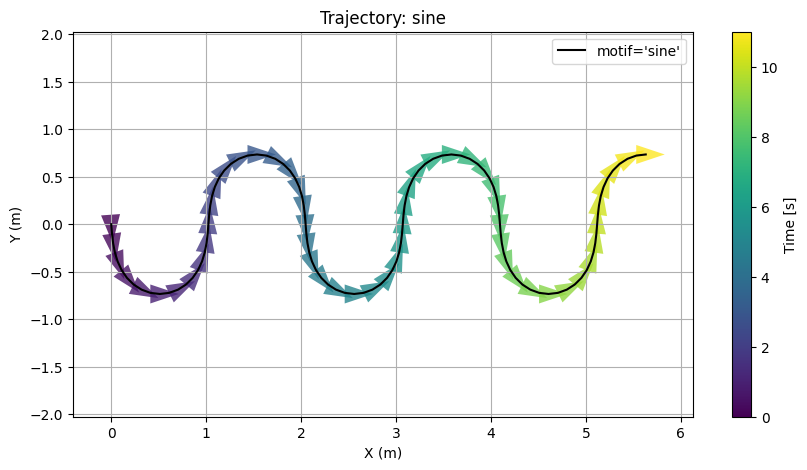

In [4]:
###################################################
# mapping = {
#             'all':  self.all_motifs,
#             'sine': self.sine_wave_motif,
#             'constant_accel': self.constant_accel_motif,
#             'constant_velocity': self.constant_velocity_motif,
#             'constant_velocity_yaw': self.constant_velocity_yaw_motif
#         }
EVERYTHING= ['constant_velocity' , 'constant_velocity_yaw', 'constant_accel', 'sine','sine_constant_heading']
###################################################

traj_gen = TrajectoryGenerator()

motif_type= 'sine'  # 'sine', 'constant_accel', 'constant_velocity', 'constant_velocity_yaw', or 'EVERYTHING
if motif_type == 'EVERYTHING':
    # run all motifs except 'all' save in dictionary for each output ie tsim['constant_velocity'] and tsim['sine_wave'] ect
    tsim = {}
    dt = {}
    v_x = {}
    v_y = {}
    psi = {}
    psi_global = {}
    x_dot = {}
    y_dot = {}
    z = {}
    X0_sim = {}
    for motif in EVERYTHING:
        print(f'Generating motif: {motif}')
        tsim[motif], dt[motif], v_x[motif], v_y[motif], psi[motif], psi_global[motif], x_dot[motif], y_dot[motif], z[motif], X0_sim[motif] = traj_gen.motifs(motif=motif)
        traj_gen.plot_trajectory(motif=motif)
else:
    print(f'Generating motif: {motif_type}')
    tsim, dt, v_x, v_y, psi, psi_global, x_dot, y_dot, z, X0_sim = traj_gen.motifs(motif=motif_type)
    traj_gen.plot_trajectory()



In [5]:
# remove the 7 and 8th elements from X0_sim
# x, y, z, v_x, v_y, v_z, phi, theta, psi, omega_x, omega_y, omega_z, wx, wy = np.ravel(X)
# x, y, z, v_x, v_y, v_z, psi, wx, wy = np.ravel(X)
# x, y, z, v_x, v_y, v_z, phi, theta, psi, wx, wy = np.ravel(X)
if FLAG == '1':
    pass
elif FLAG == '2' or FLAG == '3':
    X0_sim = np.delete(X0_sim, [6, 7, 9, 10, 11], axis=0)
elif FLAG == '4':
    X0_sim = np.delete(X0_sim, [9, 10, 11], axis=0)
X0_sim
print(X0_sim[-2], X0_sim[-1])

1.5 2.0


# run MPC

In [6]:
if motif_type == 'EVERYTHING':
    print('Running simulation for all motifs...')
    simulator = {}
    t_sim = {}
    x_sim = {}
    u_sim = {}
    y_sim = {}
    for motif in EVERYTHING:
        print(f'Running simulation for motif: {motif}')
        # Create simulator
        simulator[motif] = DroneSimulator(dt=dt[motif], mpc_horizon=50, r_u=1e-4, control_mode='velocity_body_level',params=PARAMS)
        # Update the setpoints
        simulator[motif].update_setpoint(v_x=v_x[motif], v_y=v_y[motif], psi=psi[motif], z=z[motif], wx=np.ones_like(z[motif])*X0_sim[motif][-2], wy=np.ones_like(z[motif])*X0_sim[motif][-1])
        # Run simulation
        st = time.time()
        t_sim[motif], x_sim[motif], u_sim[motif], y_sim[motif] = simulator[motif].simulate(x0=X0_sim[motif], mpc=True, return_full_output=True)
        et = time.time()
        print('elapsed time:', et-st)
else:
    print(f'Running simulation for just motif: {motif_type}')
    # Create simulator
    simulator = DroneSimulator(dt=dt, mpc_horizon=50, r_u=1e-4, control_mode='velocity_body_level',params=PARAMS)
    # Update the setpoints
    simulator.update_setpoint(v_x=v_x, v_y=v_y, psi=psi, z=z, wx=np.ones_like(z)*X0_sim[-2], wy=np.ones_like(z)*X0_sim[-1])
    # Run simulation
    st = time.time()
    # t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=X0_sim, u=U_real, mpc=False, return_full_output=True)
    t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=X0_sim, mpc=True, return_full_output=True)
    et = time.time()
    print('elapsed time:', et-st)

Running simulation for just motif: sine
in 1
Drone parameters: {'g': 9.81, 'm': 0.086, 'M': 2.529, 'Mm': 2.8729999999999998, 'L': 0.2032, 'R': 0.1778, 'I_x': 0.491, 'I_y': 0.387, 'I_z': 0.667, 'b': 1.34, 'd': 1.0, 'C': 0.1}
elapsed time: 30.782057762145996


In [7]:
# dictionary to csv 
y_sim.keys()
y_sim_df = pd.DataFrame(y_sim)
# add 'output' to the names of the columns
y_sim_df.columns = [f'output_{col}' for col in y_sim_df.columns]
# y_sim_df.to_csv(f'/home/austinlopez/Drone_AFRL/simulation/simulated_outputs_{motif_type}.csv', index=False)
x_sim_df = pd.DataFrame(x_sim)
# add 'state' to the names of the columns
x_sim_df.columns = [f'state_{col}' for col in x_sim_df.columns]
# x_sim_df.to_csv(f'/home/austinlopez/Drone_AFRL/simulation/simulated_states_{motif_type}.csv', index=False)
u_sim_df = pd.DataFrame(u_sim)
# add 'control' to the names of the columns
u_sim_df.columns = [f'control_{col}' for col in u_sim_df.columns]
# u_sim_df.to_csv(f'/home/austinlopez/Drone_AFRL/simulation/simulated_inputs_{motif_type}.csv', index=False)
t_sim_df = pd.DataFrame(t_sim, columns=['time'])

#combine all dataframes into one
simulated_data_df = pd.concat([t_sim_df, x_sim_df, u_sim_df, y_sim_df], axis=1)

print( simulated_data_df.head() )
# save the dataframe to a csv file
simulated_data_df.to_csv(f'/home/jaden/repos/Drone_AFRL/sim_data/{motif_type}.csv', index=False)

   time   state_x   state_y   state_z  state_v_x  state_v_y  state_v_z  \
0   0.0  0.000000  0.000000  2.000000   1.000000   0.000000   0.000000   
1   0.1  0.007440 -0.099253  1.992526   0.991316  -0.004400  -0.149418   
2   0.2  0.017364 -0.197806  1.983746   0.991201  -0.008998  -0.026526   
3   0.3  0.034225 -0.295696  1.986212   0.996555  -0.005419   0.075090   
4   0.4  0.062251 -0.391481  1.994146   1.000566  -0.001581   0.082805   

   state_phi  state_theta  state_psi  ...  output_wy  output_Ax  output_Ay  \
0   0.000000     0.000000  -1.500000  ...        2.0  -0.100553   0.057004   
1  -0.016652     0.004916  -1.485156  ...        2.0  -0.046404  -0.048046   
2  -0.057601     0.012654  -1.434535  ...        2.0   0.034785   0.016196   
3  -0.104147     0.014656  -1.343018  ...        2.0   0.049245   0.120222   
4  -0.142904     0.011488  -1.215940  ...        2.0   0.024357   0.236265   

   output_Az  output_Axt  output_Ayt  output_rx  output_ry  output_Wax  \
0  -1.496526

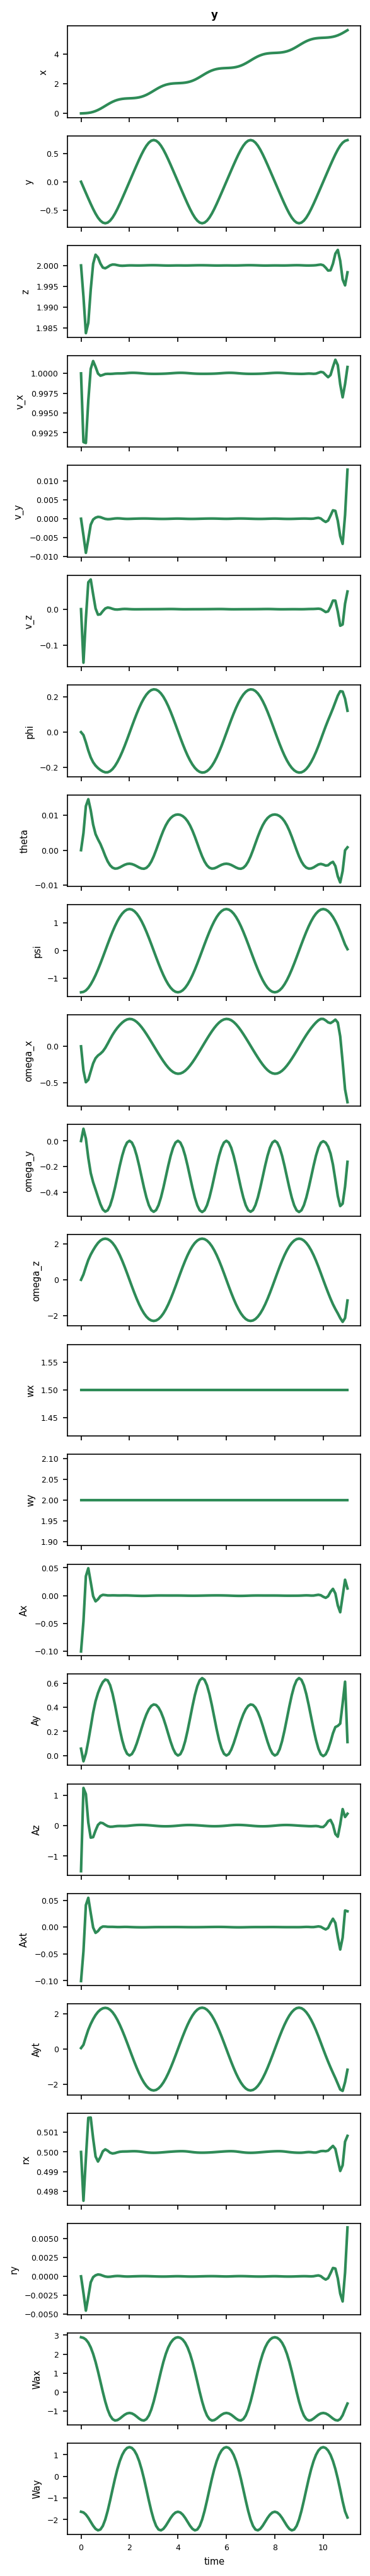

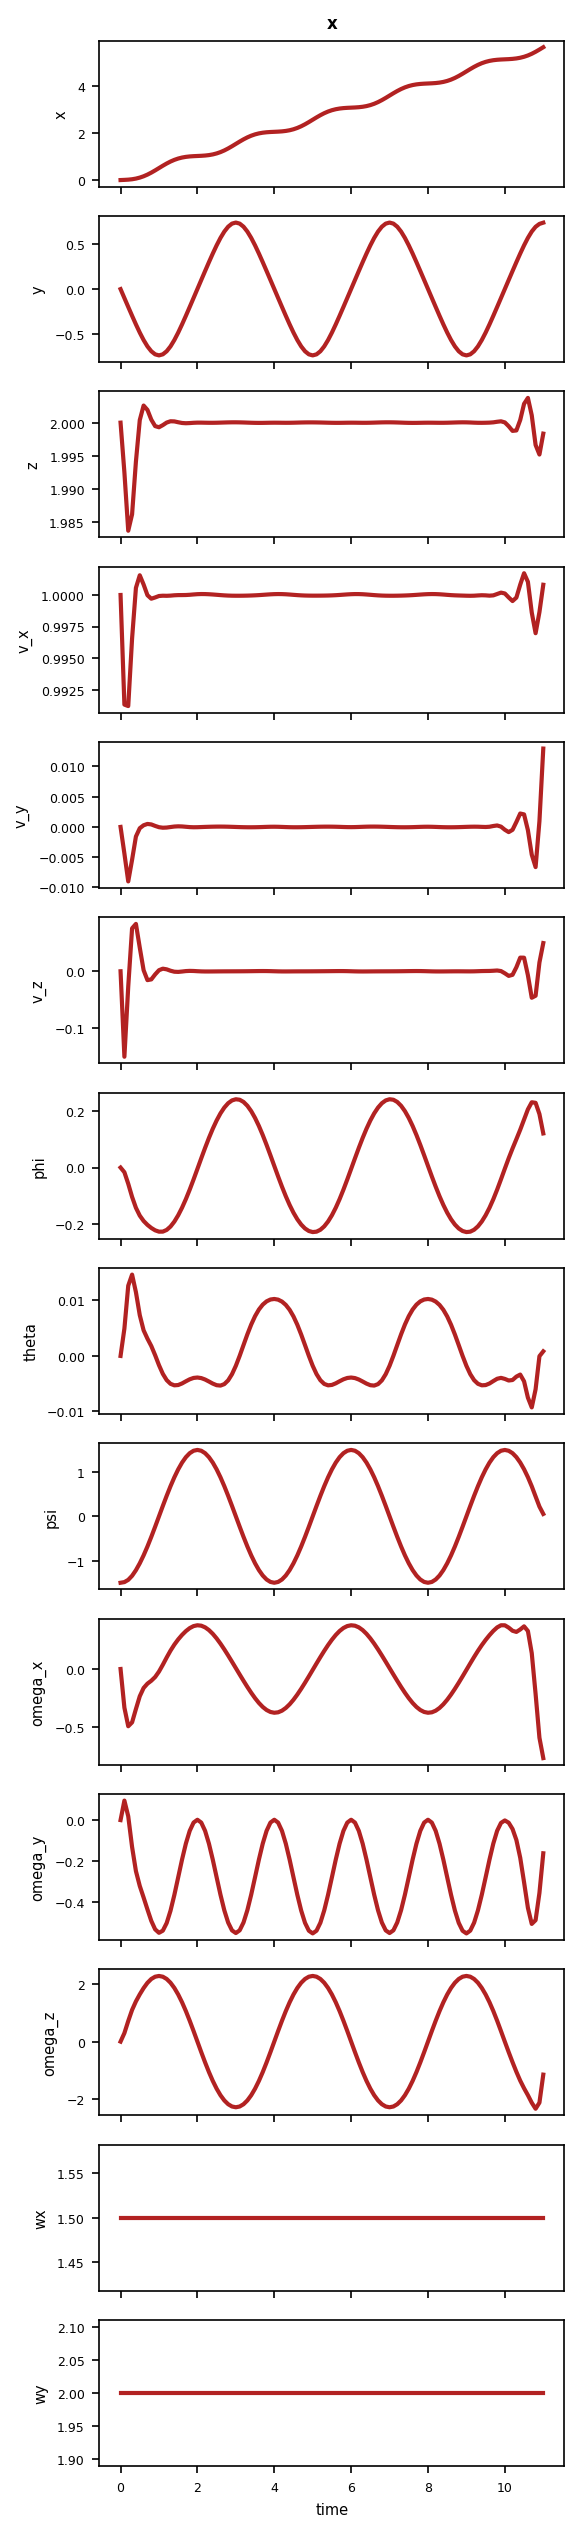

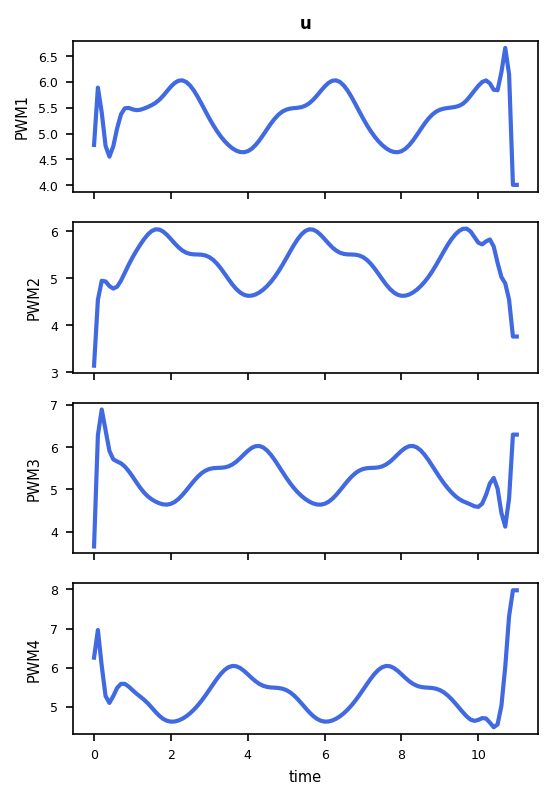

In [8]:
simulator.plot(name='y')
simulator.plot(name='x')
simulator.plot(name='u')

In [9]:
# test = u_sim['u_y']-x_sim['v_x']*u_sim['u_psi']
# plt.plot(t_sim, test, label='test = u_sim[u_y]-x_sim[v_x]*u_sim[u_psi]')
# plt.xlabel('Time [s]')
# # plt.ylabel('Value')
# plt.title('Test Plot')
# plt.legend()
# plt.grid()
# plt.show()

In [10]:
x_sim_test = pd.DataFrame(x_sim)

In [11]:
# drone_model = DroneModel()
# f_c=drone_model.f_c_car

# def outer(func):
#     def wrapper(*args, **kwargs):
#         global dt
#         args = list(args) + [dt]
#         value = func(*args)
#         return value
#     return wrapper

# f_c = outer(drone_model.f_c_car)

In [12]:
drone_model = DroneModel()
sim=drone_model.simulate

def outer(func):
    def wrapper(*args, **kwargs):
        global dt
        args = list(args) + [dt]
        value = func(*args)
        return value
    return wrapper

sim = outer(drone_model.simulate)

In [13]:
x_sim_df = pd.DataFrame(x_sim)
u_sim_df = pd.DataFrame(u_sim)

t_sim_new, x_sim_new, u_sim_new, y_sim_new = sim(x_sim_df, u_sim_df)

In [14]:
t_sim

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. ])

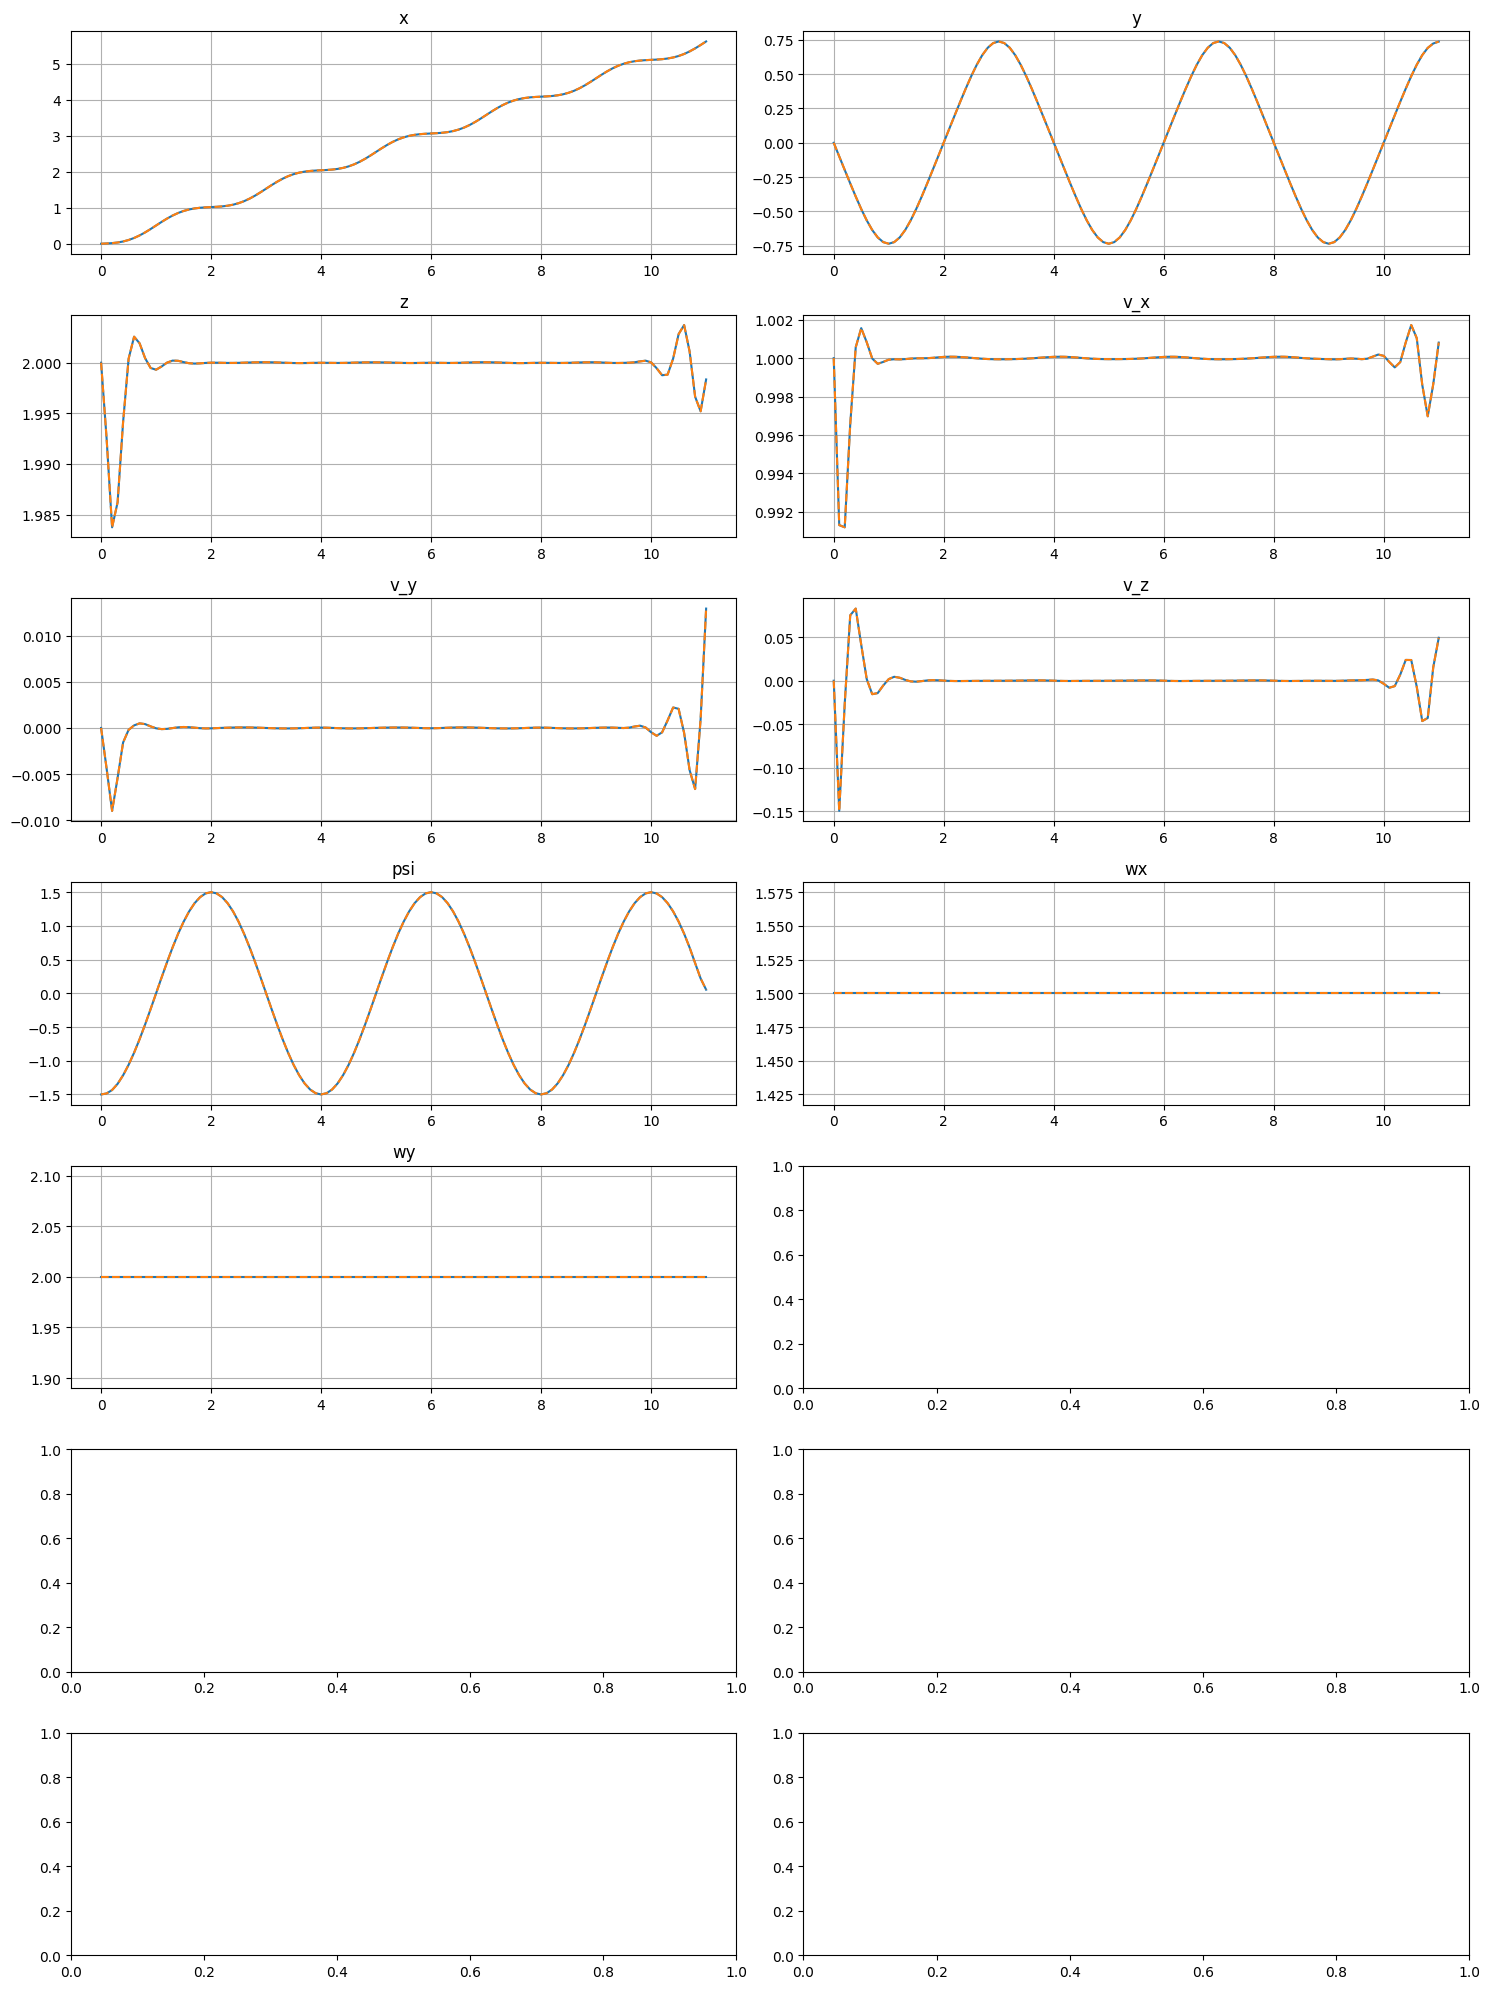

In [15]:
# plot all the states comparing x_sim and x_sim_new
if FLAG == '1':
    state_names = ['x', 'y', 'z', 'v_x', 'v_y', 'v_z', 'phi', 'theta', 'psi', 'omega_x', 'omega_y', 'omega_z', 'wx', 'wy']
    fig, axs = plt.subplots(7, 2, figsize=(15, 20))
    axs = axs.flatten()
    # state_names = ['x', 'y', 'z', 'v_x', 'v_y', 'v_z', 'phi', 'theta', 'psi', 'omega_x', 'omega_y', 'omega_z', 'wx', 'wy']
    state_names = ['x', 'y', 'z', 'v_x', 'v_y', 'v_z', 'psi', 'wx', 'wy']
    for i, state in enumerate(state_names):
        axs[i].plot(t_sim, x_sim_df[f'{state}'])
        axs[i].plot(t_sim_new, x_sim_new[f'{state}'], linestyle='--')
        axs[i].set_title(state)
        # axs[i].legend()
        axs[i].grid()
    plt.tight_layout()
    plt.show()
elif FLAG == '2' or FLAG == '3':
    fig, axs = plt.subplots(5, 2, figsize=(15, 20))
    axs = axs.flatten()
    # state_names = ['x', 'y', 'z', 'v_x', 'v_y', 'v_z', 'phi', 'theta', 'psi', 'omega_x', 'omega_y', 'omega_z', 'wx', 'wy']
    state_names = ['x', 'y', 'z', 'v_x', 'v_y', 'v_z', 'psi', 'wx', 'wy']
    for i, state in enumerate(state_names):
        axs[i].plot(t_sim, x_sim_df[f'{state}'])
        axs[i].plot(t_sim_new, x_sim_new[f'{state}'], linestyle='--')
        axs[i].set_title(state)
        # axs[i].legend()
        axs[i].grid()
    plt.tight_layout()
    plt.show()
elif FLAG == '4':
    fig, axs = plt.subplots(6, 2, figsize=(15, 20))
    axs = axs.flatten()
    # state_names = ['x', 'y', 'z', 'v_x', 'v_y', 'v_z', 'phi', 'theta', 'psi', 'omega_x', 'omega_y', 'omega_z', 'wx', 'wy']
    state_names = ['x', 'y', 'z', 'v_x', 'v_y', 'v_z', 'phi', 'theta', 'psi', 'wx', 'wy']
    for i, state in enumerate(state_names):
        axs[i].plot(t_sim, x_sim_df[f'{state}'])
        axs[i].plot(t_sim_new, x_sim_new[f'{state}'], linestyle='--')
        axs[i].set_title(state)
        # axs[i].legend()
        axs[i].grid()
    plt.tight_layout()
    plt.show()


# set up EKF

In [16]:
SENSORS = ['IMU', 'IMU + OPTIC_FLOW', 'IMU + WIND', 'IMU + WIND + OPTIC_FLOW']
Y_SWEEP = 'ALL'  # 'IMU', 'IMU + OPTIC_FLOW', 'IMU + WIND', 'IMU + WIND + OPTIC_FLOW', or 'ALL' 
# if Y_SWEEP == 'ALL':
#     # run all Y_SWEEPs
#     Y_SWEEP = ['IMU', 'IMU + OPTIC_FLOW', 'IMU + WIND', 'IMU + WIND + OPTIC_FLOW']
# else:
#     # just run the specified Y_SWEEP
#     Y_SWEEP = Y_SWEEP.copy()



### get the EKF model

In [17]:
drone_model = DroneModel()
# f_c=drone_model.f_c_car2

def outer(func):
    def wrapper(*args, **kwargs):
        global dt
        args = list(args) + [dt]
        value = func(*args)
        return value
    return wrapper
if FLAG == '1':
    f_c = outer(drone_model.f_c_car)
elif FLAG == '2':
    f_c = outer(drone_model.f_c_car2)
elif FLAG == '3':
    f_c = outer(drone_model.f_c_car3)
elif FLAG == '4':
    f_c = outer(drone_model.f_c_car4)

ALL_SENSORS = ['IMU',
               'IMU + OPTIC_FLOW',
               'IMU + WIND',
               'IMU + WIND + OPTIC_FLOW']

# 3) Write a decorator that takes an “input_sensor” string (default None).
#    If input_sensor is not None, it will always call h_c_small(..., input_sensor).
#    If input_sensor is None, it will use the global Y_SWEEP instead.

def outer_h(func, input_sensor=None):
    if input_sensor is None:
        # If no explicit sensor is passed, use whatever Y_SWEEP currently is
        def wrapper(*args, **kwargs):
            global Y_SWEEP
            # Convert args → list, append Y_SWEEP, then call func
            full_args = list(args) + [Y_SWEEP]
            return func(*full_args)
    else:
        # If input_sensor is provided in the decorator, always use that
        def wrapper(*args, **kwargs):
            full_args = list(args) + [input_sensor]
            return func(*full_args)
    return wrapper


# 4) Now build h_c depending on whether Y_SWEEP == 'ALL' or not:

if Y_SWEEP == 'ALL':
    # We want h_c to be a dict:  { sensor_str: wrapped_function, … }
    h_c = {}
    h_c_ukf = {}
    for sensor_name in ALL_SENSORS:
        print(f'getting measurement dynamics for sensors: {sensor_name}')
        # Decorate h_c_car so that it always receives sensor_name as its last argument
        if FLAG == '1':
            h_c[sensor_name] = outer_h(drone_model.h_c_car, input_sensor=sensor_name)
        elif FLAG == '2':
            h_c[sensor_name] = outer_h(drone_model.h_c_car2, input_sensor=sensor_name)
        elif FLAG == '3':
            h_c[sensor_name] = outer_h(drone_model.h_c_car3, input_sensor=sensor_name)
        elif FLAG == '4':
            h_c[sensor_name] = outer_h(drone_model.h_c_car4, input_sensor=sensor_name)

else:
    # Only a single sensor is requested—wrap h_c_car so it uses whatever Y_SWEEP is
    print(f'getting measurement dynamics for sensors: {Y_SWEEP}')
    if FLAG == '1':
        h_c = outer_h(drone_model.h_c_car, input_sensor=Y_SWEEP)
    elif FLAG == '2':
        h_c = outer_h(drone_model.h_c_car2, input_sensor=Y_SWEEP)
    elif FLAG == '3':
        h_c = outer_h(drone_model.h_c_car3, input_sensor=Y_SWEEP)
    elif FLAG == '4':
        h_c = outer_h(drone_model.h_c_car4, input_sensor=Y_SWEEP)


getting measurement dynamics for sensors: IMU
getting measurement dynamics for sensors: IMU + OPTIC_FLOW
getting measurement dynamics for sensors: IMU + WIND
getting measurement dynamics for sensors: IMU + WIND + OPTIC_FLOW


### set up the measurments

##### add noise to the simulated data

In [18]:
# creat new dictionary that is a copy of y_sim called y_sim_noise
y_sim_noise = y_sim.copy()
# add noise to y_sim_noise
# mocap postion noise in standard deviations
if FLAG == '1':
    pose_noise_std = 0.1
    y_sim_noise['x'] = y_sim['x'] + np.random.normal(0, pose_noise_std, size=y_sim['x'].shape)
    y_sim_noise['y'] = y_sim['y'] + np.random.normal(0, pose_noise_std, size=y_sim['y'].shape)
    y_sim_noise['z'] = y_sim['z'] + np.random.normal(0, pose_noise_std, size=y_sim['z'].shape)
    velocity_noise_std = 0.1
    y_sim_noise['v_x'] = y_sim['v_x'] + np.random.normal(0, velocity_noise_std, size=y_sim['v_x'].shape)
    y_sim_noise['v_y'] = y_sim['v_y'] + np.random.normal(0, velocity_noise_std, size=y_sim['v_y'].shape)
    y_sim_noise['v_z'] = y_sim['v_z'] + np.random.normal(0, velocity_noise_std, size=y_sim['v_z'].shape)
    attitude_noise_std = 0.1
    y_sim_noise['phi'] = y_sim['phi'] + np.random.normal(0, attitude_noise_std, size=y_sim['phi'].shape)
    y_sim_noise['theta'] = y_sim['theta'] + np.random.normal(0, attitude_noise_std, size=y_sim['theta'].shape)
    y_sim_noise['psi'] = y_sim['psi'] + np.random.normal(0, attitude_noise_std, size=y_sim['psi'].shape)
    omega_noise_std = 0.1
    y_sim_noise['omega_x'] = y_sim['omega_x'] + np.random.normal(0, omega_noise_std, size=y_sim['omega_x'].shape)
    y_sim_noise['omega_y'] = y_sim['omega_y'] + np.random.normal(0, omega_noise_std, size=y_sim['omega_y'].shape)
    y_sim_noise['omega_z'] = y_sim['omega_z'] + np.random.normal(0, omega_noise_std, size=y_sim['omega_z'].shape)
    acc_noise_std = 0.1
    y_sim_noise['Axt'] = y_sim['Axt'] + np.random.normal(0, acc_noise_std, size=y_sim['Axt'].shape)
    y_sim_noise['Ayt'] = y_sim['Ayt'] + np.random.normal(0, acc_noise_std, size=y_sim['Ayt'].shape)
    y_sim_noise['Az'] = y_sim['Az'] + np.random.normal(0, acc_noise_std, size=y_sim['Az'].shape)
    wind_noise_std = 0.1
    y_sim_noise['Wax'] = y_sim['Wax'] + np.random.normal(0, wind_noise_std, size=y_sim['Wax'].shape)
    y_sim_noise['Way'] = y_sim['Way'] + np.random.normal(0, wind_noise_std, size=y_sim['Way'].shape)
    of_noise_std = 0.1
    y_sim_noise['rx'] = y_sim['rx'] + np.random.normal(0, of_noise_std, size=y_sim['rx'].shape)
    y_sim_noise['ry'] = y_sim['ry'] + np.random.normal(0, of_noise_std, size=y_sim['ry'].shape)
elif FLAG == '2' or FLAG == '3':
    pose_noise_std = 0.1
    y_sim_noise['x'] = y_sim['x'] + np.random.normal(0, pose_noise_std, size=y_sim['x'].shape)
    y_sim_noise['y'] = y_sim['y'] + np.random.normal(0, pose_noise_std, size=y_sim['y'].shape)
    y_sim_noise['z'] = y_sim['z'] + np.random.normal(0, pose_noise_std, size=y_sim['z'].shape)
    velocity_noise_std = 0.1
    y_sim_noise['v_x'] = y_sim['v_x'] + np.random.normal(0, velocity_noise_std, size=y_sim['v_x'].shape)
    y_sim_noise['v_y'] = y_sim['v_y'] + np.random.normal(0, velocity_noise_std, size=y_sim['v_y'].shape)
    y_sim_noise['v_z'] = y_sim['v_z'] + np.random.normal(0, velocity_noise_std, size=y_sim['v_z'].shape)
    attitude_noise_std = 0.1
    y_sim_noise['psi'] = y_sim['psi'] + np.random.normal(0, attitude_noise_std, size=y_sim['psi'].shape)
    acc_noise_std = 0.1
    y_sim_noise['Ax'] = y_sim['Ax'] + np.random.normal(0, acc_noise_std, size=y_sim['Ax'].shape)
    y_sim_noise['Ay'] = y_sim['Ay'] + np.random.normal(0, acc_noise_std, size=y_sim['Ay'].shape)
    y_sim_noise['Az'] = y_sim['Az'] + np.random.normal(0, acc_noise_std, size=y_sim['Az'].shape)
    wind_noise_std = 0.1
    y_sim_noise['Wax'] = y_sim['Wax'] + np.random.normal(0, wind_noise_std, size=y_sim['Wax'].shape)
    y_sim_noise['Way'] = y_sim['Way'] + np.random.normal(0, wind_noise_std, size=y_sim['Way'].shape)
    of_noise_std = 0.1
    y_sim_noise['rx'] = y_sim['rx'] + np.random.normal(0, of_noise_std, size=y_sim['rx'].shape)
    y_sim_noise['ry'] = y_sim['ry'] + np.random.normal(0, of_noise_std, size=y_sim['ry'].shape)
elif FLAG == '4':
    pose_noise_std = 0.1
    y_sim_noise['x'] = y_sim['x'] + np.random.normal(0, pose_noise_std, size=y_sim['x'].shape)
    y_sim_noise['y'] = y_sim['y'] + np.random.normal(0, pose_noise_std, size=y_sim['y'].shape)
    y_sim_noise['z'] = y_sim['z'] + np.random.normal(0, pose_noise_std, size=y_sim['z'].shape)
    velocity_noise_std = 0.1
    y_sim_noise['v_x'] = y_sim['v_x'] + np.random.normal(0, velocity_noise_std, size=y_sim['v_x'].shape)
    y_sim_noise['v_y'] = y_sim['v_y'] + np.random.normal(0, velocity_noise_std, size=y_sim['v_y'].shape)
    y_sim_noise['v_z'] = y_sim['v_z'] + np.random.normal(0, velocity_noise_std, size=y_sim['v_z'].shape)
    attitude_noise_std = 0.1
    y_sim_noise['phi'] = y_sim['phi'] + np.random.normal(0, attitude_noise_std, size=y_sim['phi'].shape)
    y_sim_noise['theta'] = y_sim['theta'] + np.random.normal(0, attitude_noise_std, size=y_sim['theta'].shape)
    y_sim_noise['psi'] = y_sim['psi'] + np.random.normal(0, attitude_noise_std, size=y_sim['psi'].shape)
    acc_noise_std = 0.1
    y_sim_noise['Ax'] = y_sim['Ax'] + np.random.normal(0, acc_noise_std, size=y_sim['Ax'].shape)
    y_sim_noise['Ay'] = y_sim['Ay'] + np.random.normal(0, acc_noise_std, size=y_sim['Ay'].shape)
    y_sim_noise['Az'] = y_sim['Az'] + np.random.normal(0, acc_noise_std, size=y_sim['Az'].shape)
    wind_noise_std = 0.1
    y_sim_noise['Wax'] = y_sim['Wax'] + np.random.normal(0, wind_noise_std, size=y_sim['Wax'].shape)
    y_sim_noise['Way'] = y_sim['Way'] + np.random.normal(0, wind_noise_std, size=y_sim['Way'].shape)
    of_noise_std = 0.1
    y_sim_noise['rx'] = y_sim['rx'] + np.random.normal(0, of_noise_std, size=y_sim['rx'].shape)
    y_sim_noise['ry'] = y_sim['ry'] + np.random.normal(0, of_noise_std, size=y_sim['ry'].shape)

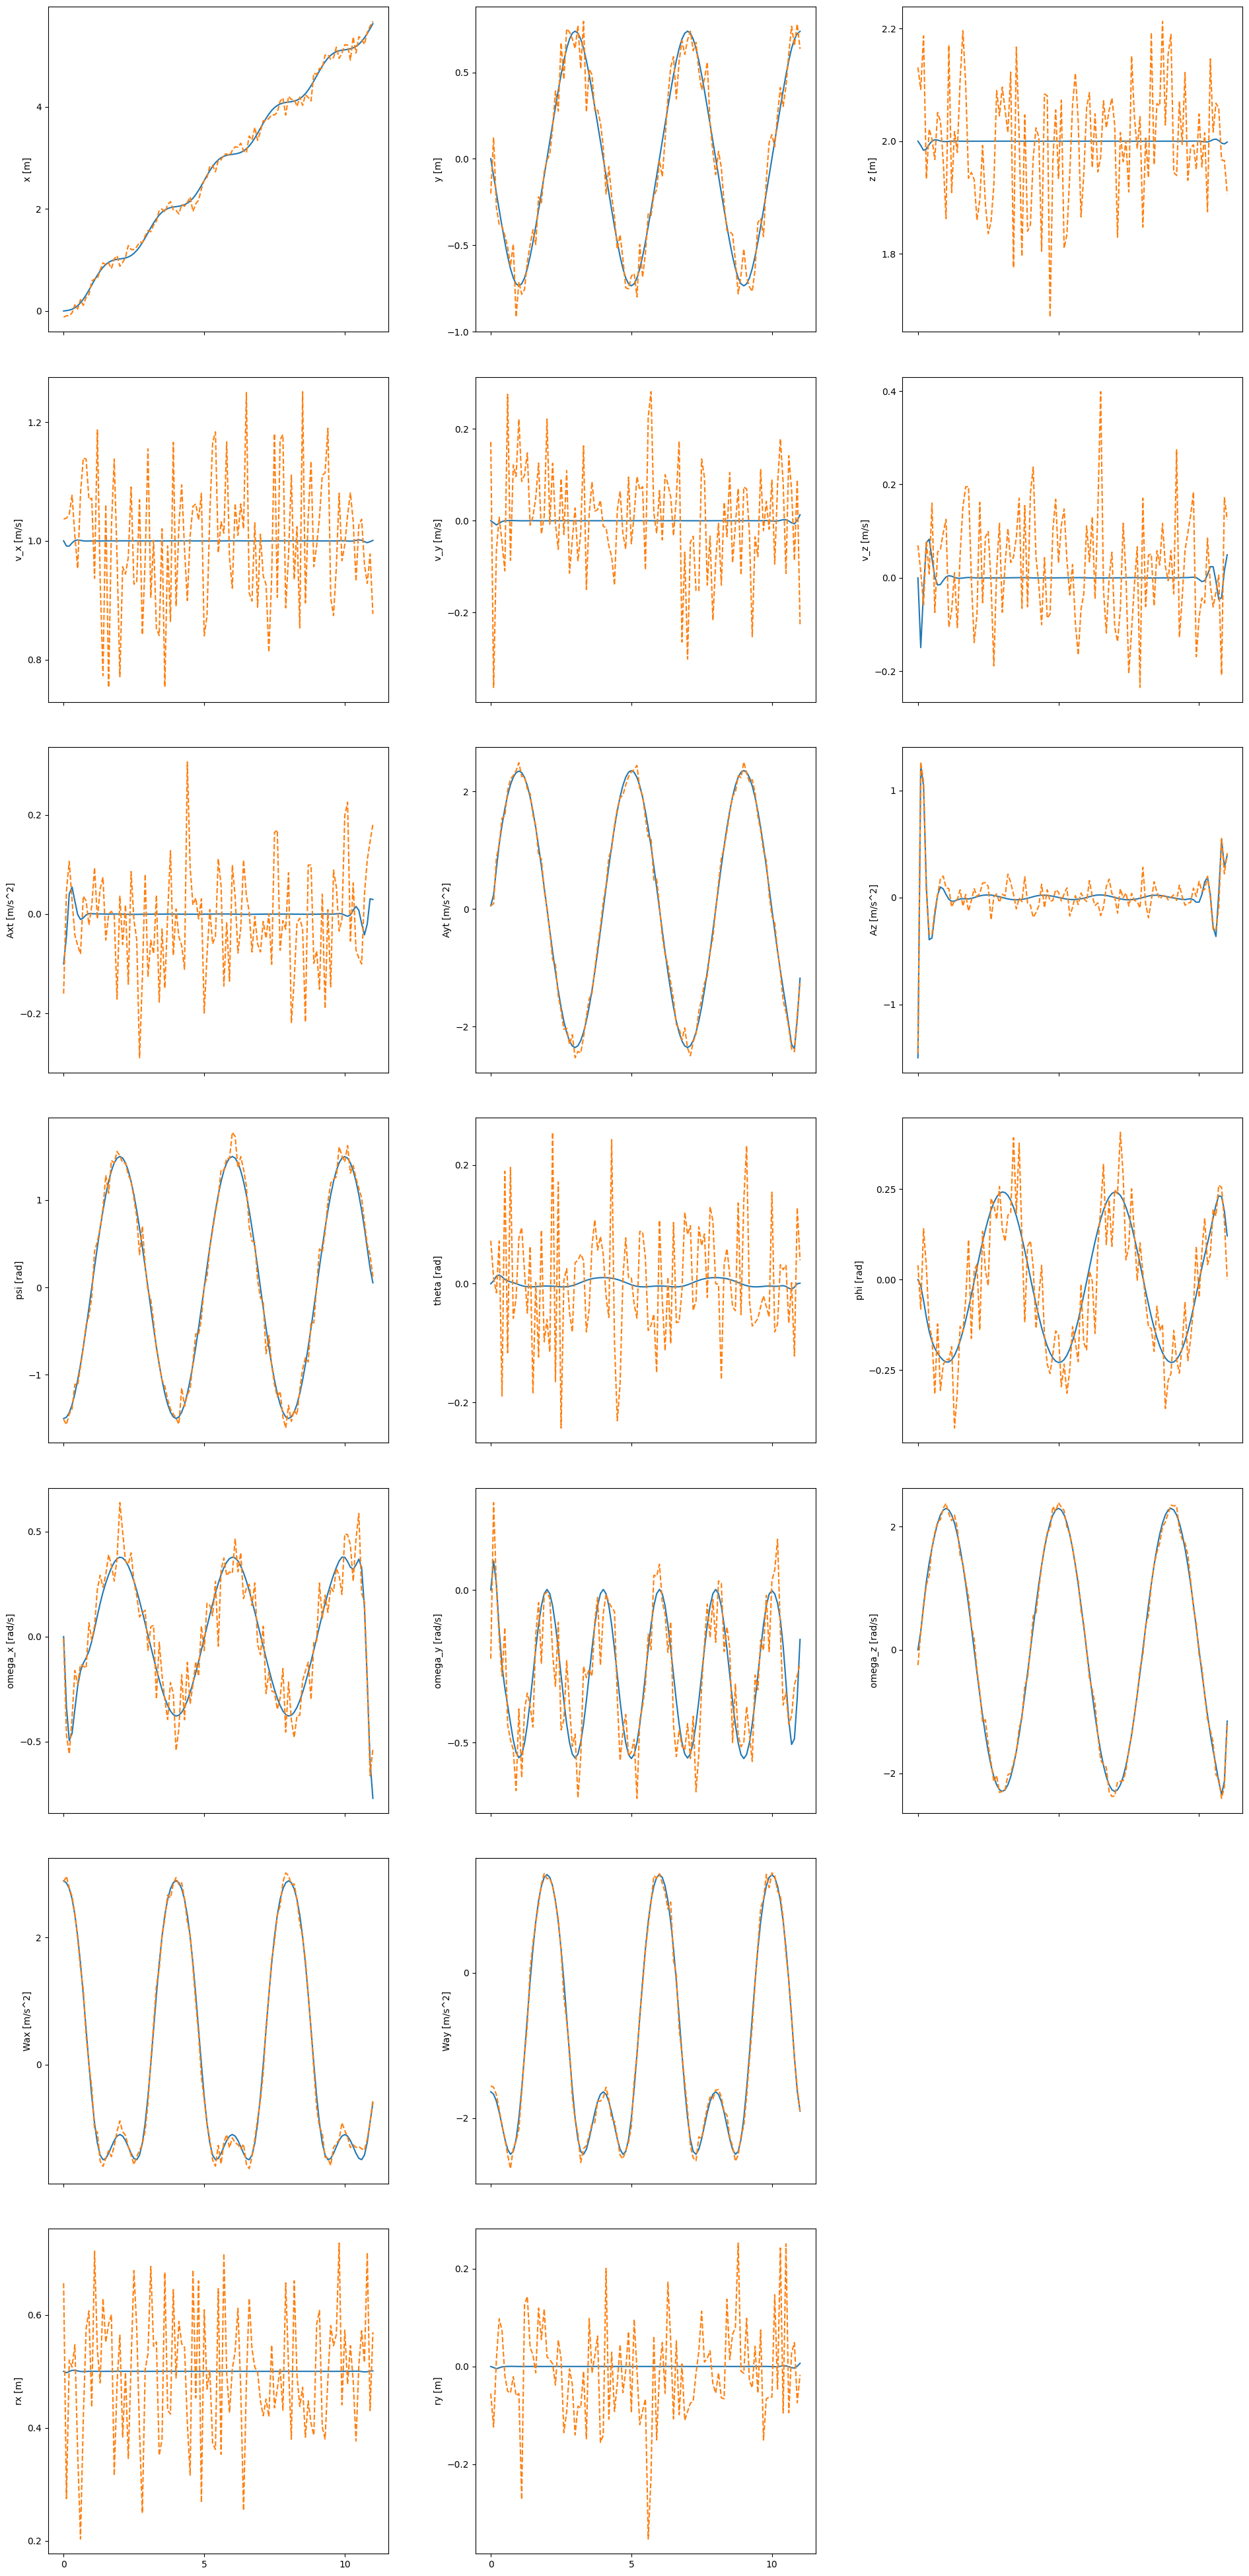

In [ ]:
if FLAG == '1':
    # plot y_sim and y_sim_noise
    fig, ax = plt.subplots(7, 3, figsize=(20, 40), sharex=True)
    # set test size
    xhat, P, S = EKF(Y_noise, Xo, f_c, h_c, Q, R, U, P0)
    mpl.rcParams['font.size'] = 40
    ax[0, 0].plot(t_sim, y_sim['x'], label='x')
    ax[0, 0].plot(t_sim, y_sim_noise['x'], label='x noise', linestyle='--')
    ax[0, 0].set_ylabel('x [m]')
    ax[0, 1].plot(t_sim, y_sim['y'], label='y')
    ax[0, 1].plot(t_sim, y_sim_noise['y'], label='y noise', linestyle='--')
    ax[0, 1].set_ylabel('y [m]')
    ax[0, 2].plot(t_sim, y_sim['z'], label='z')
    ax[0, 2].plot(t_sim, y_sim_noise['z'], label='z noise', linestyle='--')
    ax[0, 2].set_ylabel('z [m]')
    ax[1, 0].plot(t_sim, y_sim['v_x'], label='v_x')
    ax[1, 0].plot(t_sim, y_sim_noise['v_x'], label='v_x noise', linestyle='--')
    ax[1, 0].set_ylabel('v_x [m/s]')
    ax[1, 1].plot(t_sim, y_sim['v_y'], label='v_y')
    ax[1, 1].plot(t_sim, y_sim_noise['v_y'], label='v_y noise', linestyle='--')
    ax[1, 1].set_ylabel('v_y [m/s]')
    ax[1, 2].plot(t_sim, y_sim['v_z'], label='v_z')
    ax[1, 2].plot(t_sim, y_sim_noise['v_z'], label='v_z noise', linestyle='--')
    ax[1, 2].set_ylabel('v_z [m/s]')
    ax[2, 0].plot(t_sim, y_sim['Axt'], label='Axt')
    ax[2, 0].plot(t_sim, y_sim_noise['Axt'], label='Axt noise', linestyle='--')
    ax[2, 0].set_ylabel('Axt [m/s^2]')
    ax[2, 1].plot(t_sim, y_sim['Ayt'], label='Ayt')
    ax[2, 1].plot(t_sim, y_sim_noise['Ayt'], label='Ayt noise', linestyle='--')
    ax[2, 1].set_ylabel('Ayt [m/s^2]')
    ax[2, 2].plot(t_sim, y_sim['Az'], label='Az')
    ax[2, 2].plot(t_sim, y_sim_noise['Az'], label='Az noise', linestyle='--')
    ax[2, 2].set_ylabel('Az [m/s^2]')
    ax[3, 0].plot(t_sim, y_sim['psi'], label='psi')
    ax[3, 0].plot(t_sim, y_sim_noise['psi'], label='psi noise', linestyle='--')
    ax[3, 0].set_ylabel('psi [rad]')
    ax[3, 1].plot(t_sim, y_sim['theta'], label='theta')
    ax[3, 1].plot(t_sim, y_sim_noise['theta'], label='theta noise', linestyle='--')
    ax[3, 1].set_ylabel('theta [rad]')
    ax[3, 2].plot(t_sim, y_sim['phi'], label='phi')
    ax[3, 2].plot(t_sim, y_sim_noise['phi'], label='phi noise', linestyle='--')
    ax[3, 2].set_ylabel('phi [rad]')
    ax[4, 0].plot(t_sim, y_sim['omega_x'], label='omega_x')
    ax[4, 0].plot(t_sim, y_sim_noise['omega_x'], label='omega_x noise', linestyle='--')
    ax[4, 0].set_ylabel('omega_x [rad/s]')
    ax[4, 1].plot(t_sim, y_sim['omega_y'], label='omega_y')
    ax[4, 1].plot(t_sim, y_sim_noise['omega_y'], label='omega_y noise', linestyle='--')
    ax[4, 1].set_ylabel('omega_y [rad/s]')
    ax[4, 2].plot(t_sim, y_sim['omega_z'], label='omega_z')
    ax[4, 2].plot(t_sim, y_sim_noise['omega_z'], label='omega_z noise', linestyle='--')
    ax[4, 2].set_ylabel('omega_z [rad/s]')
    ax[5, 0].plot(t_sim, y_sim['Wax'], label='Wax')
    ax[5, 0].plot(t_sim, y_sim_noise['Wax'], label='Wax noise', linestyle='--')
    ax[5, 0].set_ylabel('Wax [m/s^2]')
    ax[5, 1].plot(t_sim, y_sim['Way'], label='Way')
    ax[5, 1].plot(t_sim, y_sim_noise['Way'], label='Way noise', linestyle='--')
    ax[5, 1].set_ylabel('Way [m/s^2]')
    ax[5, 2].set_visible(False)  # Hide the empty subplot
    ax[6, 0].plot(t_sim, y_sim['rx'], label='rx')
    ax[6, 0].plot(t_sim, y_sim_noise['rx'], label='rx noise', linestyle='--')
    ax[6, 0].set_ylabel('rx [m]')
    ax[6, 1].plot(t_sim, y_sim['ry'], label='ry')
    ax[6, 1].plot(t_sim, y_sim_noise['ry'], label='ry noise', linestyle='--')
    ax[6, 1].set_ylabel('ry [m]')
    ax[6, 2].set_visible(False)  # Hide the empty subplot

    plt.tight_layout()
    plt.show()
elif FLAG == '2' or FLAG == '3':
    # plot y_sim and y_sim_noise
    fig, ax = plt.subplots(6, 3, figsize=(20, 40), sharex=True)
    # set test size
    mpl.rcParams['font.size'] = 40
    ax[0, 0].plot(t_sim, y_sim['x'], label='x')
    ax[0, 0].plot(t_sim, y_sim_noise['x'], label='x noise', linestyle='--')
    ax[0, 0].set_ylabel('x [m]')
    ax[0, 1].plot(t_sim, y_sim['y'], label='y')
    ax[0, 1].plot(t_sim, y_sim_noise['y'], label='y noise', linestyle='--')
    ax[0, 1].set_ylabel('y [m]')
    ax[0, 2].plot(t_sim, y_sim['z'], label='z')
    ax[0, 2].plot(t_sim, y_sim_noise['z'], label='z noise', linestyle='--')
    ax[0, 2].set_ylabel('z [m]')
    ax[1, 0].plot(t_sim, y_sim['v_x'], label='v_x')
    ax[1, 0].plot(t_sim, y_sim_noise['v_x'], label='v_x noise', linestyle='--')
    ax[1, 0].set_ylabel('v_x [m/s]')
    ax[1, 1].plot(t_sim, y_sim['v_y'], label='v_y')
    ax[1, 1].plot(t_sim, y_sim_noise['v_y'], label='v_y noise', linestyle='--')
    ax[1, 1].set_ylabel('v_y [m/s]')
    ax[1, 2].plot(t_sim, y_sim['v_z'], label='v_z')
    ax[1, 2].plot(t_sim, y_sim_noise['v_z'], label='v_z noise', linestyle='--')
    ax[1, 2].set_ylabel('v_z [m/s]')
    ax[2, 0].plot(t_sim, y_sim['Ax'], label='Ax')
    ax[2, 0].plot(t_sim, y_sim_noise['Ax'], label='Ax noise', linestyle='--')
    ax[2, 0].set_ylabel('Ax [m/s^2]')
    ax[2, 1].plot(t_sim, y_sim['Ay'], label='Ay')
    ax[2, 1].plot(t_sim, y_sim_noise['Ay'], label='Ay noise', linestyle='--')
    ax[2, 1].set_ylabel('Ay [m/s^2]')
    ax[2, 2].plot(t_sim, y_sim['Az'], label='Az')
    ax[2, 2].plot(t_sim, y_sim_noise['Az'], label='Az noise', linestyle='--')
    ax[2, 2].set_ylabel('Az [m/s^2]')
    ax[3, 0].plot(t_sim, y_sim['psi'], label='psi')
    ax[3, 0].plot(t_sim, y_sim_noise['psi'], label='psi noise', linestyle='--')
    ax[3, 0].set_ylabel('psi [rad]')
    ax[4, 0].plot(t_sim, y_sim['Wax'], label='Wax')
    ax[4, 0].plot(t_sim, y_sim_noise['Wax'], label='Wax noise', linestyle='--')
    ax[4, 0].set_ylabel('Wax [m/s^2]')
    ax[4, 1].plot(t_sim, y_sim['Way'], label='Way')
    ax[4, 1].plot(t_sim, y_sim_noise['Way'], label='Way noise', linestyle='--')
    ax[4, 1].set_ylabel('Way [m/s^2]')
    ax[4, 2].set_visible(False)  # Hide the empty subplot
    ax[5, 0].plot(t_sim, y_sim['rx'], label='rx')
    ax[5, 0].plot(t_sim, y_sim_noise['rx'], label='rx noise', linestyle='--')
    ax[5, 0].set_ylabel('rx [m]')
    ax[5, 1].plot(t_sim, y_sim['ry'], label='ry')
    ax[5, 1].plot(t_sim, y_sim_noise['ry'], label='ry noise', linestyle='--')
    ax[5, 1].set_ylabel('ry [m]')
    ax[5, 2].set_visible(False)  # Hide the empty subplot

    plt.tight_layout()
    plt.show()

elif FLAG == '4':
    # plot y_sim and y_sim_noise
    fig, ax = plt.subplots(7, 3, figsize=(20, 40), sharex=True)
    # set test size
    mpl.rcParams['font.size'] = 40
    ax[0, 0].plot(t_sim, y_sim['x'], label='x')
    ax[0, 0].plot(t_sim, y_sim_noise['x'], label='x noise', linestyle='--')
    ax[0, 0].set_ylabel('x [m]')
    ax[0, 1].plot(t_sim, y_sim['y'], label='y')
    ax[0, 1].plot(t_sim, y_sim_noise['y'], label='y noise', linestyle='--')
    ax[0, 1].set_ylabel('y [m]')
    ax[0, 2].plot(t_sim, y_sim['z'], label='z')
    ax[0, 2].plot(t_sim, y_sim_noise['z'], label='z noise', linestyle='--')
    ax[0, 2].set_ylabel('z [m]')
    ax[1, 0].plot(t_sim, y_sim['v_x'], label='v_x')
    ax[1, 0].plot(t_sim, y_sim_noise['v_x'], label='v_x noise', linestyle='--')
    ax[1, 0].set_ylabel('v_x [m/s]')
    ax[1, 1].plot(t_sim, y_sim['v_y'], label='v_y')
    ax[1, 1].plot(t_sim, y_sim_noise['v_y'], label='v_y noise', linestyle='--')
    ax[1, 1].set_ylabel('v_y [m/s]')
    ax[1, 2].plot(t_sim, y_sim['v_z'], label='v_z')
    ax[1, 2].plot(t_sim, y_sim_noise['v_z'], label='v_z noise', linestyle='--')
    ax[1, 2].set_ylabel('v_z [m/s]')
    ax[2, 0].plot(t_sim, y_sim['Ax'], label='Ax')
    ax[2, 0].plot(t_sim, y_sim_noise['Ax'], label='Ax noise', linestyle='--')
    ax[2, 0].set_ylabel('Ax [m/s^2]')
    ax[2, 1].plot(t_sim, y_sim['Ay'], label='Ay')
    ax[2, 1].plot(t_sim, y_sim_noise['Ay'], label='Ay noise', linestyle='--')
    ax[2, 1].set_ylabel('Ay [m/s^2]')
    ax[2, 2].plot(t_sim, y_sim['Az'], label='Az')
    ax[2, 2].plot(t_sim, y_sim_noise['Az'], label='Az noise', linestyle='--')
    ax[2, 2].set_ylabel('Az [m/s^2]')
    ax[3, 0].plot(t_sim, y_sim['phi'], label='phi')
    ax[3, 0].plot(t_sim, y_sim_noise['phi'], label='phi noise', linestyle='--')
    ax[3, 0].set_ylabel('phi [rad]')
    ax[3, 1].plot(t_sim, y_sim['theta'], label='theta')
    ax[3, 1].plot(t_sim, y_sim_noise['theta'], label='theta noise', linestyle='--')
    ax[3, 1].set_ylabel('theta [rad]')
    ax[3, 2].plot(t_sim, y_sim['psi'], label='psi')
    ax[3, 2].plot(t_sim, y_sim_noise['psi'], label='psi noise', linestyle='--')
    ax[3, 2].set_ylabel('psi [rad]')
    ax[4, 0].plot(t_sim, y_sim['Wax'], label='Wax')
    ax[4, 0].plot(t_sim, y_sim_noise['Wax'], label='Wax noise', linestyle='--')
    ax[4, 0].set_ylabel('Wax [m/s]')
    ax[4, 1].plot(t_sim, y_sim['Way'], label='Way')
    ax[4, 1].plot(t_sim, y_sim_noise['Way'], label='Way noise', linestyle='--')
    ax[4, 1].set_ylabel('Way [m/s]')
    ax[4, 2].set_visible(False)
    ax[5, 0].plot(t_sim, y_sim['rx'], label='rx')
    ax[5, 0].plot(t_sim, y_sim_noise['rx'], label='rx noise', linestyle='--')
    ax[5, 0].set_ylabel('rx [m/s]')
    ax[5, 1].plot(t_sim, y_sim['ry'], label='ry')
    ax[5, 1].plot(t_sim, y_sim_noise['ry'], label='ry noise', linestyle='--')
    ax[5, 1].set_ylabel('ry [m/s]')
    ax[5, 2].set_visible(False)

In [20]:
# g= np.sqrt(y_sim_noise['v_x']**2 + y_sim_noise['v_y']**2)
# beta = np.arctan2(y_sim_noise['v_y'], y_sim_noise['v_x'])
# a= np.sqrt(y_sim_noise['Wax']**2 + y_sim_noise['Way']**2)
# gamma = np.arctan2(y_sim_noise['Way'], y_sim_noise['Wax'])
# psi = y_sim_noise['psi']
# w_true= np.sqrt(x_sim['wx']**2 + x_sim['wy']**2)
# zeta_true = np.arctan2(x_sim['wy'], x_sim['wx'])
# gv= g*np.exp(-1j*beta)
# av= a*np.exp(-1j*gamma)
# wv = av - gv

# w= np.abs(wv)
# zeta = np.angle(wv)+ psi

# print('wind speed error:', np.mean(np.abs(w - w_true)))
# print('wind direction error:', np.mean(np.abs(zeta - zeta_true)))

# plt.plot(t_sim, w_true, label='w_true')
# plt.plot(t_sim, w, label='w')
# plt.xlabel('time [s]')
# plt.ylabel('wind speed [m/s]')
# plt.legend()
# plt.show()
# plt.plot(t_sim, zeta_true, label='zeta_true')
# plt.plot(t_sim, zeta, label='zeta')
# plt.xlabel('time [s]')
# plt.ylabel('wind direction [rad]')
# plt.legend()
# plt.show()

##### cluster the data based on the sensors sweep

In [21]:
if FLAG == '1':
    P_cluster = np.array(np.vstack([y_sim_noise['x'], y_sim_noise['y'], y_sim_noise['z']]))
    V_cluster = np.array(np.vstack([y_sim_noise['v_x'], y_sim_noise['v_y'], y_sim_noise['v_z']]))
    Attitude_cluster = np.array(np.vstack([y_sim_noise['phi'], y_sim_noise['theta'], y_sim_noise['psi']]))
    Omega_cluster = np.array(np.vstack([y_sim_noise['omega_x'], y_sim_noise['omega_y'], y_sim_noise['omega_z']]))
    Acc_cluster = np.array(np.vstack([y_sim_noise['Axt'], y_sim_noise['Ayt'], y_sim_noise['Az']]))
    IMU_cluster = np.array(np.vstack([y_sim_noise['phi'], y_sim_noise['theta'], y_sim_noise['psi'], y_sim_noise['omega_x'], y_sim_noise['omega_y'], y_sim_noise['omega_z'], y_sim_noise['Axt'], y_sim_noise['Ayt'], y_sim_noise['Az']]))
    Wind_cluster = np.array(np.vstack([y_sim_noise['Wax'], y_sim_noise['Way']]))
    OF_cluster = np.array(np.vstack([y_sim_noise['rx'], y_sim_noise['ry']]))
elif FLAG == '2' or FLAG == '3':
    P_cluster = np.array(np.vstack([y_sim_noise['x'], y_sim_noise['y'], y_sim_noise['z']]))
    V_cluster = np.array(np.vstack([y_sim_noise['v_x'], y_sim_noise['v_y'], y_sim_noise['v_z']]))
    Attitude_cluster = np.array(np.vstack([y_sim_noise['psi']]))
    Acc_cluster = np.array(np.vstack([y_sim_noise['Ax'], y_sim_noise['Ay'], y_sim_noise['Az']]))
    IMU_cluster = np.array(np.vstack([y_sim_noise['psi'], y_sim_noise['Ax'], y_sim_noise['Ay'], y_sim_noise['Az']]))
    Wind_cluster = np.array(np.vstack([y_sim_noise['Wax'], y_sim_noise['Way']]))
    OF_cluster = np.array(np.vstack([y_sim_noise['rx'], y_sim_noise['ry']]))
elif FLAG == '4':
    P_cluster = np.array(np.vstack([y_sim_noise['x'], y_sim_noise['y'], y_sim_noise['z']]))
    V_cluster = np.array(np.vstack([y_sim_noise['v_x'], y_sim_noise['v_y'], y_sim_noise['v_z']]))
    Attitude_cluster = np.array(np.vstack([y_sim_noise['phi'], y_sim_noise['theta'], y_sim_noise['psi']]))
    Acc_cluster = np.array(np.vstack([y_sim_noise['Ax'], y_sim_noise['Ay'], y_sim_noise['Az']]))
    IMU_cluster = np.array(np.vstack([y_sim_noise['phi'], y_sim_noise['theta'], y_sim_noise['psi'], y_sim_noise['Ax'], y_sim_noise['Ay'], y_sim_noise['Az']]))
    Wind_cluster = np.array(np.vstack([y_sim_noise['Wax'], y_sim_noise['Way']]))
    OF_cluster = np.array(np.vstack([y_sim_noise['rx'], y_sim_noise['ry']]))


if Y_SWEEP == 'ALL':
    print('Running all sensors...')
    Y_noise = {}
    for sensor in SENSORS:
        if sensor == 'IMU':
            Y_noise[sensor] = np.vstack((IMU_cluster))
        elif sensor == 'IMU + OPTIC_FLOW':
            Y_noise[sensor] = np.vstack((IMU_cluster, OF_cluster))
        elif sensor == 'IMU + WIND':
            Y_noise[sensor] = np.vstack((IMU_cluster, Wind_cluster))
        elif sensor == 'IMU + WIND + OPTIC_FLOW':
            Y_noise[sensor] = np.vstack((IMU_cluster, OF_cluster, Wind_cluster))
        elif sensor == 'IMU + VEL + WIND':
            Y_noise[sensor] = np.vstack((IMU_cluster, V_cluster, Wind_cluster))
        else:
            raise ValueError('Invalid sensor type')
    print(f'Running sensors: {list(Y_noise.keys())}')
else:
    print(f'Running sensors: {Y_SWEEP}')
    if Y_SWEEP == 'IMU':
        Y_noise = np.vstack((IMU_cluster))
    elif Y_SWEEP == 'IMU + OPTIC_FLOW':
        Y_noise = np.vstack((IMU_cluster, OF_cluster))
    elif Y_SWEEP == 'IMU + WIND':
        Y_noise = np.vstack((IMU_cluster, Wind_cluster))
    elif Y_SWEEP == 'IMU + WIND + OPTIC_FLOW':
        Y_noise = np.vstack((IMU_cluster, OF_cluster, Wind_cluster))
    elif Y_SWEEP == 'IMU + VEL + WIND':
        Y_noise = np.vstack((IMU_cluster, V_cluster, Wind_cluster))
    else:
        raise ValueError('Invalid Y_SWEEP value')

Running all sensors...
Running sensors: ['IMU', 'IMU + OPTIC_FLOW', 'IMU + WIND', 'IMU + WIND + OPTIC_FLOW']


### get the control inputs U

In [22]:
if FLAG == '1':
    U = np.array(np.vstack([u_sim['PWM1'], u_sim['PWM2'], u_sim['PWM3'], u_sim['PWM4']]))
elif FLAG == '2' or FLAG == '3':
    U = np.array(np.vstack([u_sim['u_x'], u_sim['u_y'], u_sim['u_z'], u_sim['u_psi']]))
elif FLAG == '4':
    U = np.array(np.vstack([u_sim['u_thrust'], u_sim['u_phi'], u_sim['u_theta'], u_sim['u_psi']]))

### get the initial condition and add some offset to them

In [23]:
x0_x_offset = 1.0
x0_y_offset = 1.0
x0_z_offset = 1.0
x0_v_x_offset = 1.0
x0_v_y_offset = 1.0
x0_v_z_offset = 1.0
x0_psi_offset = 1.0
x0_theta_offset = 1.0
x0_phi_offset = 1.0
x0_omega_x_offset = 1.0
x0_omega_y_offset = 1.0
x0_omega_z_offset = 1.0
x0_wx_offset = 1.0
x0_wy_offset = 1.0

if FLAG == '1':
    Xo= np.atleast_2d(np.vstack((
    X0_sim[0] + x0_x_offset,X0_sim[1] + x0_y_offset,X0_sim[2] + x0_z_offset,
    X0_sim[3] + x0_v_x_offset,X0_sim[4] + x0_v_y_offset,X0_sim[5] + x0_v_z_offset,
    X0_sim[6] + x0_phi_offset,X0_sim[7] + x0_theta_offset,X0_sim[8] + x0_psi_offset,
    X0_sim[9] + x0_omega_x_offset,X0_sim[10] + x0_omega_y_offset,X0_sim[11] + x0_omega_z_offset,
    X0_sim[12] + x0_wx_offset,X0_sim[13] + x0_wy_offset
    )))
elif FLAG == '2' or FLAG == '3':
    Xo= np.atleast_2d(np.vstack((
        X0_sim[0] + x0_x_offset, X0_sim[1] + x0_y_offset, X0_sim[2] + x0_z_offset,
        X0_sim[3] + x0_v_x_offset, X0_sim[4] + x0_v_y_offset, X0_sim[5] + x0_v_z_offset,
        X0_sim[6] + x0_psi_offset,
        X0_sim[7] + x0_wx_offset, X0_sim[8] + x0_wy_offset
    )))
elif FLAG == '4':
    Xo= np.atleast_2d(np.vstack((
        X0_sim[0] + x0_x_offset, X0_sim[1] + x0_y_offset, X0_sim[2] + x0_z_offset,
        X0_sim[3] + x0_v_x_offset, X0_sim[4] + x0_v_y_offset, X0_sim[5] + x0_v_z_offset,
        X0_sim[6] + x0_phi_offset, X0_sim[7] + x0_theta_offset, X0_sim[8] + x0_psi_offset,
        X0_sim[9] + x0_wx_offset, X0_sim[10] + x0_wy_offset
    )))

### System Covariance Q

In [24]:
if FLAG == '1':
    Q = np.diag(np.array([
    1e-20, 1e-20, 1e-20,  # x, y, z
    1e-20, 1e-20, 1e-20,  # v_x, v_y, v_z
    1e-20, 1e-20, 1e-20,  # phi, theta, psi
    1e-20, 1e-20, 1e-20,  # omega_x, omega_y, omega_z
    1e-20, 1e-20        # wx, wy
    ]))
elif FLAG == '2' or FLAG == '3':
    Q = np.diag(np.array([
        1e-2, 1e-2, 1e-2,  # x, y, z
        1e-2, 1e-2, 1e-2,  # v_x, v_y, v_z
        1e-2,                # psi
        1e-2, 1e-2          # wx, wy
    ]))
elif FLAG == '4':
    Q = np.diag(np.array([
        1e-2, 1e-2, 1e-2,  # x, y, z
        1e-2, 1e-2, 1e-2,  # v_x, v_y, v_z
        1e-2, 1e-2, 1e-2,  # phi, theta, psi
        1e-2, 1e-2          # wx, wy
    ]))

### Error covariance R

In [25]:
if FLAG == '1':
    if Y_SWEEP == 'ALL':
        R={}
        for sensor in SENSORS:
            if sensor == 'IMU':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
                    omega_noise_std, omega_noise_std, omega_noise_std,  # omega_x, omega_y, omega_z
                    acc_noise_std, acc_noise_std, acc_noise_std  # Ax, Ay, Az
                ])), 2)
            elif sensor == 'IMU + OPTIC_FLOW':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
                    omega_noise_std, omega_noise_std, omega_noise_std,  # omega_x, omega_y, omega_z
                    acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
                    of_noise_std, of_noise_std  # rx, ry
                ])), 2)
            elif sensor == 'IMU + WIND':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
                    omega_noise_std, omega_noise_std, omega_noise_std,  # omega_x, omega_y, omega_z
                    acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
                    wind_noise_std, wind_noise_std  # Wax, Way
                ])), 2)
            elif sensor == 'IMU + WIND + OPTIC_FLOW':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std, attitude_noise_std, attitude_noise_std,
                    omega_noise_std, omega_noise_std, omega_noise_std,
                    acc_noise_std, acc_noise_std, acc_noise_std,
                    of_noise_std, of_noise_std,
                    wind_noise_std, wind_noise_std
                ])), 2)
            elif sensor == 'IMU + VEL + WIND':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
                    omega_noise_std, omega_noise_std, omega_noise_std,  # omega_x, omega_y, omega_z
                    acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
                    velocity_noise_std, velocity_noise_std, velocity_noise_std,  # v_x, v_y, v_z
                    wind_noise_std, wind_noise_std  # Wax, Way
                ])), 2)

    elif Y_SWEEP == 'IMU':
        R = np.power(np.diag(np.array([
            attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
            omega_noise_std, omega_noise_std, omega_noise_std,  # omega_x, omega_y, omega_z
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
        ])), 2)
    elif Y_SWEEP == 'IMU + OPTIC_FLOW':
        R = np.power(np.diag(np.array([
            attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
            omega_noise_std, omega_noise_std, omega_noise_std,  # omega_x, omega_y, omega_z
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
            of_noise_std, of_noise_std  # rx, ry
        ])), 2)
    elif Y_SWEEP == 'IMU + WIND':
        R = np.power(np.diag(np.array([
            attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
            omega_noise_std, omega_noise_std, omega_noise_std,  # omega_x, omega_y, omega_z
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
            wind_noise_std, wind_noise_std  # Wax, Way
        ])), 2)
    elif Y_SWEEP == 'IMU + WIND + OPTIC_FLOW':
        R = np.power(np.diag(np.array([
            attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
            omega_noise_std, omega_noise_std, omega_noise_std,  # omega_x, omega_y, omega_z
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
            of_noise_std, of_noise_std,  # rx, ry
            wind_noise_std, wind_noise_std  # Wax, Way
        ])), 2)
    elif Y_SWEEP == 'IMU + VEL + WIND':
        R = np.power(np.diag(np.array([
            attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
            omega_noise_std, omega_noise_std, omega_noise_std,  # omega_x, omega_y, omega_z
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
            velocity_noise_std, velocity_noise_std, velocity_noise_std,  # v_x, v_y, v_z
            wind_noise_std, wind_noise_std  # Wax, Way
        ])), 2)
elif FLAG == '2' or FLAG == '3':
    if Y_SWEEP == 'ALL':
        R={}
        for sensor in SENSORS:
            if sensor == 'IMU':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std,                          # psi
                    acc_noise_std, acc_noise_std, acc_noise_std  # Ax, Ay, Az
                ])), 2)
            elif sensor == 'IMU + OPTIC_FLOW':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std,                          # psi
                    acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
                    of_noise_std, of_noise_std                    # rx, ry
                ])), 2)
            elif sensor == 'IMU + WIND':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std,                           # psi
                    acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
                    wind_noise_std, wind_noise_std                # Wax, Way
                ])), 2)
            elif sensor == 'IMU + WIND + OPTIC_FLOW':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std,                           # psi
                    acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
                    of_noise_std, of_noise_std,                   # rx, ry
                    wind_noise_std, wind_noise_std                # Wax, Way
                ])), 2)


    elif Y_SWEEP == 'IMU':
        R = np.power(np.diag(np.array([
            attitude_noise_std,  # psi
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
        ])), 2)
    elif Y_SWEEP == 'IMU + OPTIC_FLOW':
        R = np.power(np.diag(np.array([
            attitude_noise_std,  # psi
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
            of_noise_std, of_noise_std  # rx, ry
        ])), 2)
    elif Y_SWEEP == 'IMU + WIND':
        R = np.power(np.diag(np.array([
            attitude_noise_std,  # psi
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
            wind_noise_std, wind_noise_std  # Wax, Way
        ])), 2)
    elif Y_SWEEP == 'IMU + WIND + OPTIC_FLOW':
        R = np.power(np.diag(np.array([
            attitude_noise_std,  # phi, theta, psi
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
            of_noise_std, of_noise_std,  # rx, ry
            wind_noise_std, wind_noise_std  # Wax, Way
        ])), 2)
elif FLAG == '4':
    if Y_SWEEP == 'ALL':
        R={}
        for sensor in SENSORS:
            if sensor == 'IMU':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std,attitude_noise_std,attitude_noise_std, # phi theta psi
                    acc_noise_std, acc_noise_std, acc_noise_std  # Ax, Ay, Az
                ])), 2)
            elif sensor == 'IMU + OPTIC_FLOW':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std,attitude_noise_std,attitude_noise_std,  # phi, theta, psi
                    acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
                    of_noise_std, of_noise_std  # rx, ry
                ])), 2)
            elif sensor == 'IMU + WIND':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std,attitude_noise_std,attitude_noise_std,  # phi, theta, psi
                    acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
                    wind_noise_std, wind_noise_std  # Wax, Way
                ])), 2)
            elif sensor == 'IMU + WIND + OPTIC_FLOW':
                R[sensor] = np.power(np.diag(np.array([
                    attitude_noise_std,attitude_noise_std,attitude_noise_std,  # phi, theta, psi
                    acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
                    of_noise_std, of_noise_std,                   # rx, ry
                    wind_noise_std, wind_noise_std                # Wax, Way
                ])), 2)


    elif Y_SWEEP == 'IMU':
        R = np.power(np.diag(np.array([
            attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
        ])), 2)
    elif Y_SWEEP == 'IMU + OPTIC_FLOW':
        R = np.power(np.diag(np.array([
            attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
            of_noise_std, of_noise_std  # rx, ry
        ])), 2)
    elif Y_SWEEP == 'IMU + WIND':
        R = np.power(np.diag(np.array([
            attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
            wind_noise_std, wind_noise_std  # Wax, Way
        ])), 2)
    elif Y_SWEEP == 'IMU + WIND + OPTIC_FLOW':
        R = np.power(np.diag(np.array([
            attitude_noise_std, attitude_noise_std, attitude_noise_std,  # phi, theta, psi
            acc_noise_std, acc_noise_std, acc_noise_std,  # Ax, Ay, Az
            of_noise_std, of_noise_std,  # rx, ry
            wind_noise_std, wind_noise_std  # Wax, Way
        ])), 2)


### Initial estimate covariance $P_{o}$

In [26]:
if FLAG == '1':
    # Initial state covariance matrix
    P0 = np.diag(np.array([x0_x_offset, x0_y_offset, x0_z_offset,
                           x0_v_x_offset, x0_v_y_offset, x0_v_z_offset,
                           x0_phi_offset, x0_theta_offset, x0_psi_offset,
                           x0_omega_x_offset, x0_omega_y_offset, x0_omega_z_offset,
                           x0_wx_offset, x0_wy_offset]) ** 2)
elif FLAG == '2' or FLAG == '3':
    P0 = np.diag(np.array([x0_x_offset, x0_y_offset, x0_z_offset,
                           x0_v_x_offset, x0_v_y_offset, x0_v_z_offset,
                           x0_psi_offset,
                           x0_wx_offset, x0_wy_offset]) ** 2)
elif FLAG == '4':
    P0 = np.diag(np.array([x0_x_offset, x0_y_offset, x0_z_offset,
                           x0_v_x_offset, x0_v_y_offset, x0_v_z_offset,
                           x0_phi_offset, x0_theta_offset, x0_psi_offset,
                           x0_wx_offset, x0_wy_offset]) ** 2)
P0

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

### check that the size of inputs are correct

In [27]:
if Y_SWEEP == 'ALL':
    for sensor in SENSORS:
        if Y_noise[sensor].shape[0] != R[sensor].shape[0]:
            raise ValueError(f'Y_noise[{sensor}] and R[{sensor}] must have the same number of rows')
        elif Y_noise[sensor].shape[0] != R[sensor].shape[1]:
            raise ValueError(f'Y_noise[{sensor}] and R[{sensor}] must have the same number of columns')
        elif Xo.shape[0] != P0.shape[0]:
            raise ValueError(f'Xo and P0 must have the same number of rows for {sensor}')
        elif Xo.shape[0] != P0.shape[1]:
            raise ValueError(f'Xo and P0 must have the same number of columns for {sensor}')
        elif Xo.shape[0] != Q.shape[0]:
            raise ValueError(f'Xo and Q must have the same number of rows for {sensor}')
        elif Xo.shape[0] != Q.shape[1]:
            raise ValueError(f'Xo and Q must have the same number of columns for {sensor}')
        else:
            print(f'All dimensions are correct for {sensor}')
        print('Y_noise shape:', Y_noise[sensor].shape)
        print('U shape:', U.shape)
        print('R shape:', R[sensor].shape)
        print('Xo shape:', Xo.shape)
        print('P0 shape:', P0.shape)
        print('Q shape:', Q.shape)

else:
    if Y_noise.shape[0] != R.shape[0]:
        raise ValueError('Y_noise and R must have the same number of rows')
    elif Y_noise.shape[0] != R.shape[1]:
        raise ValueError('Y_noise and R must have the same number of columns')
    elif Xo.shape[0] != P0.shape[0]:
        raise ValueError('Xo and P0 must have the same number of rows')
    elif Xo.shape[0] != P0.shape[1]:
        raise ValueError('Xo and P0 must have the same number of columns')
    elif Xo.shape[0] != Q.shape[0]:
        raise ValueError('Xo and Q must have the same number of rows')
    elif Xo.shape[0] != Q.shape[1]:
        raise ValueError('Xo and Q must have the same number of columns')
    else:
        print('All dimensions are correct for just {Y_SWEEP}')

    print('Y_noise shape:', Y_noise.shape)
    print('U shape:', U.shape)
    print('R shape:', R.shape)
    print('Xo shape:', Xo.shape)
    print('P0 shape:', P0.shape)
    print('Q shape:', Q.shape)

All dimensions are correct for IMU
Y_noise shape: (9, 111)
U shape: (4, 111)
R shape: (9, 9)
Xo shape: (14, 1)
P0 shape: (14, 14)
Q shape: (14, 14)
All dimensions are correct for IMU + OPTIC_FLOW
Y_noise shape: (11, 111)
U shape: (4, 111)
R shape: (11, 11)
Xo shape: (14, 1)
P0 shape: (14, 14)
Q shape: (14, 14)
All dimensions are correct for IMU + WIND
Y_noise shape: (11, 111)
U shape: (4, 111)
R shape: (11, 11)
Xo shape: (14, 1)
P0 shape: (14, 14)
Q shape: (14, 14)
All dimensions are correct for IMU + WIND + OPTIC_FLOW
Y_noise shape: (13, 111)
U shape: (4, 111)
R shape: (13, 13)
Xo shape: (14, 1)
P0 shape: (14, 14)
Q shape: (14, 14)


# Run the EKF

In [28]:
E_FLAG = 'EKF'
if Y_SWEEP == 'ALL':
    xhat = {}
    P = {}
    S = {}
    for sensor in SENSORS:
        print(f'Running EKF for sensor: {sensor}')
        tst = time.time()
        if E_FLAG == 'EKF':
            xhat[sensor], P[sensor], S[sensor] = EKF(Y_noise[sensor], Xo, f_c, h_c[sensor], Q, R[sensor], U, P0)
        else:
            raise ValueError('Invalid E_FLAG value')

        print(f'Finished EKF for sensor: {sensor}')
        tet = time.time()
        print('elapsed time:', tet-tst)

else:
    xhat, P, S = EKF(Y_noise, Xo, f_c, h_c, Q, R, U, P0)

Running EKF for sensor: IMU
Finished EKF for sensor: IMU
elapsed time: 38.331286668777466
Running EKF for sensor: IMU + OPTIC_FLOW
Finished EKF for sensor: IMU + OPTIC_FLOW
elapsed time: 43.48045086860657
Running EKF for sensor: IMU + WIND
Finished EKF for sensor: IMU + WIND
elapsed time: 35.33486223220825
Running EKF for sensor: IMU + WIND + OPTIC_FLOW
Finished EKF for sensor: IMU + WIND + OPTIC_FLOW
elapsed time: 35.46374320983887


In [29]:
# creat dictionary from xhat
if Y_SWEEP == 'ALL':
    print('Creating xhat_dict for all sensors...')
    xhat_dict = {}
    for sensor in SENSORS:
        # xhat_dict[sensor] = {
        #     'x_hat': xhat[sensor][0, :],
        #     'y_hat': xhat[sensor][1, :],
        #     'z_hat': xhat[sensor][2, :],
        #     'v_x_hat': xhat[sensor][3, :],
        #     'v_y_hat': xhat[sensor][4, :],
        #     'v_z_hat': xhat[sensor][5, :],
        #     'psi_hat': xhat[sensor][6, :],
        #     'wx_hat': xhat[sensor][7, :],
        #     'wy_hat': xhat[sensor][8, :],
        #     'g_hat': (xhat[sensor][3, :]**2 + xhat[sensor][4, :]**2)**0.5,
        #     'beta_hat': np.arctan2(xhat[sensor][4, :], xhat[sensor][3, :]),
        #     'W_hat':(xhat[sensor][7, :]**2 + xhat[sensor][8, :]**2)**0.5,
        #     'zeta_hat': np.arctan2(xhat[sensor][8, :], xhat[sensor][7, :]),
        # }

        xhat_dict[sensor] = {
            'x_hat': xhat[sensor][0, :],
            'y_hat': xhat[sensor][1, :],
            'z_hat': xhat[sensor][2, :],
            'v_x_hat': xhat[sensor][3, :],
            'v_y_hat': xhat[sensor][4, :],
            'v_z_hat': xhat[sensor][5, :],
            'phi_hat': xhat[sensor][6, :],
            'theta_hat': xhat[sensor][7, :],
            'psi_hat': xhat[sensor][8, :],
            'wx_hat': xhat[sensor][9, :],
            'wy_hat': xhat[sensor][10, :],
            'g_hat': (xhat[sensor][3, :]**2 + xhat[sensor][4, :]**2)**0.5,
            'beta_hat': np.arctan2(xhat[sensor][4, :], xhat[sensor][3, :]),
            'W_hat':(xhat[sensor][9, :]**2 + xhat[sensor][10, :]**2)**0.5,
            'zeta_hat': np.arctan2(xhat[sensor][10, :], xhat[sensor][9, :]),
        }
else:

    xhat_dict = {
        'x_hat': xhat[0, :],
        'y_hat': xhat[1, :],
        'z_hat': xhat[2, :],
        'v_x_hat': xhat[3, :],
        'v_y_hat': xhat[4, :],
        'v_z_hat': xhat[5, :],
        'psi_hat': xhat[6, :],
        'wx_hat': xhat[7, :],
        'wy_hat': xhat[8, :],
        'g_hat': (xhat[3, :]**2 + xhat[4, :]**2)**0.5,
        'beta_hat': np.arctan2(xhat[4, :], xhat[3, :]),
        'W_hat':(xhat[7, :]**2 + xhat[8, :]**2)**0.5,
        'zeta_hat': np.arctan2(xhat[8, :], xhat[7, :]),
}

Creating xhat_dict for all sensors...


# Plotting the results

Plotting results for all sensors...


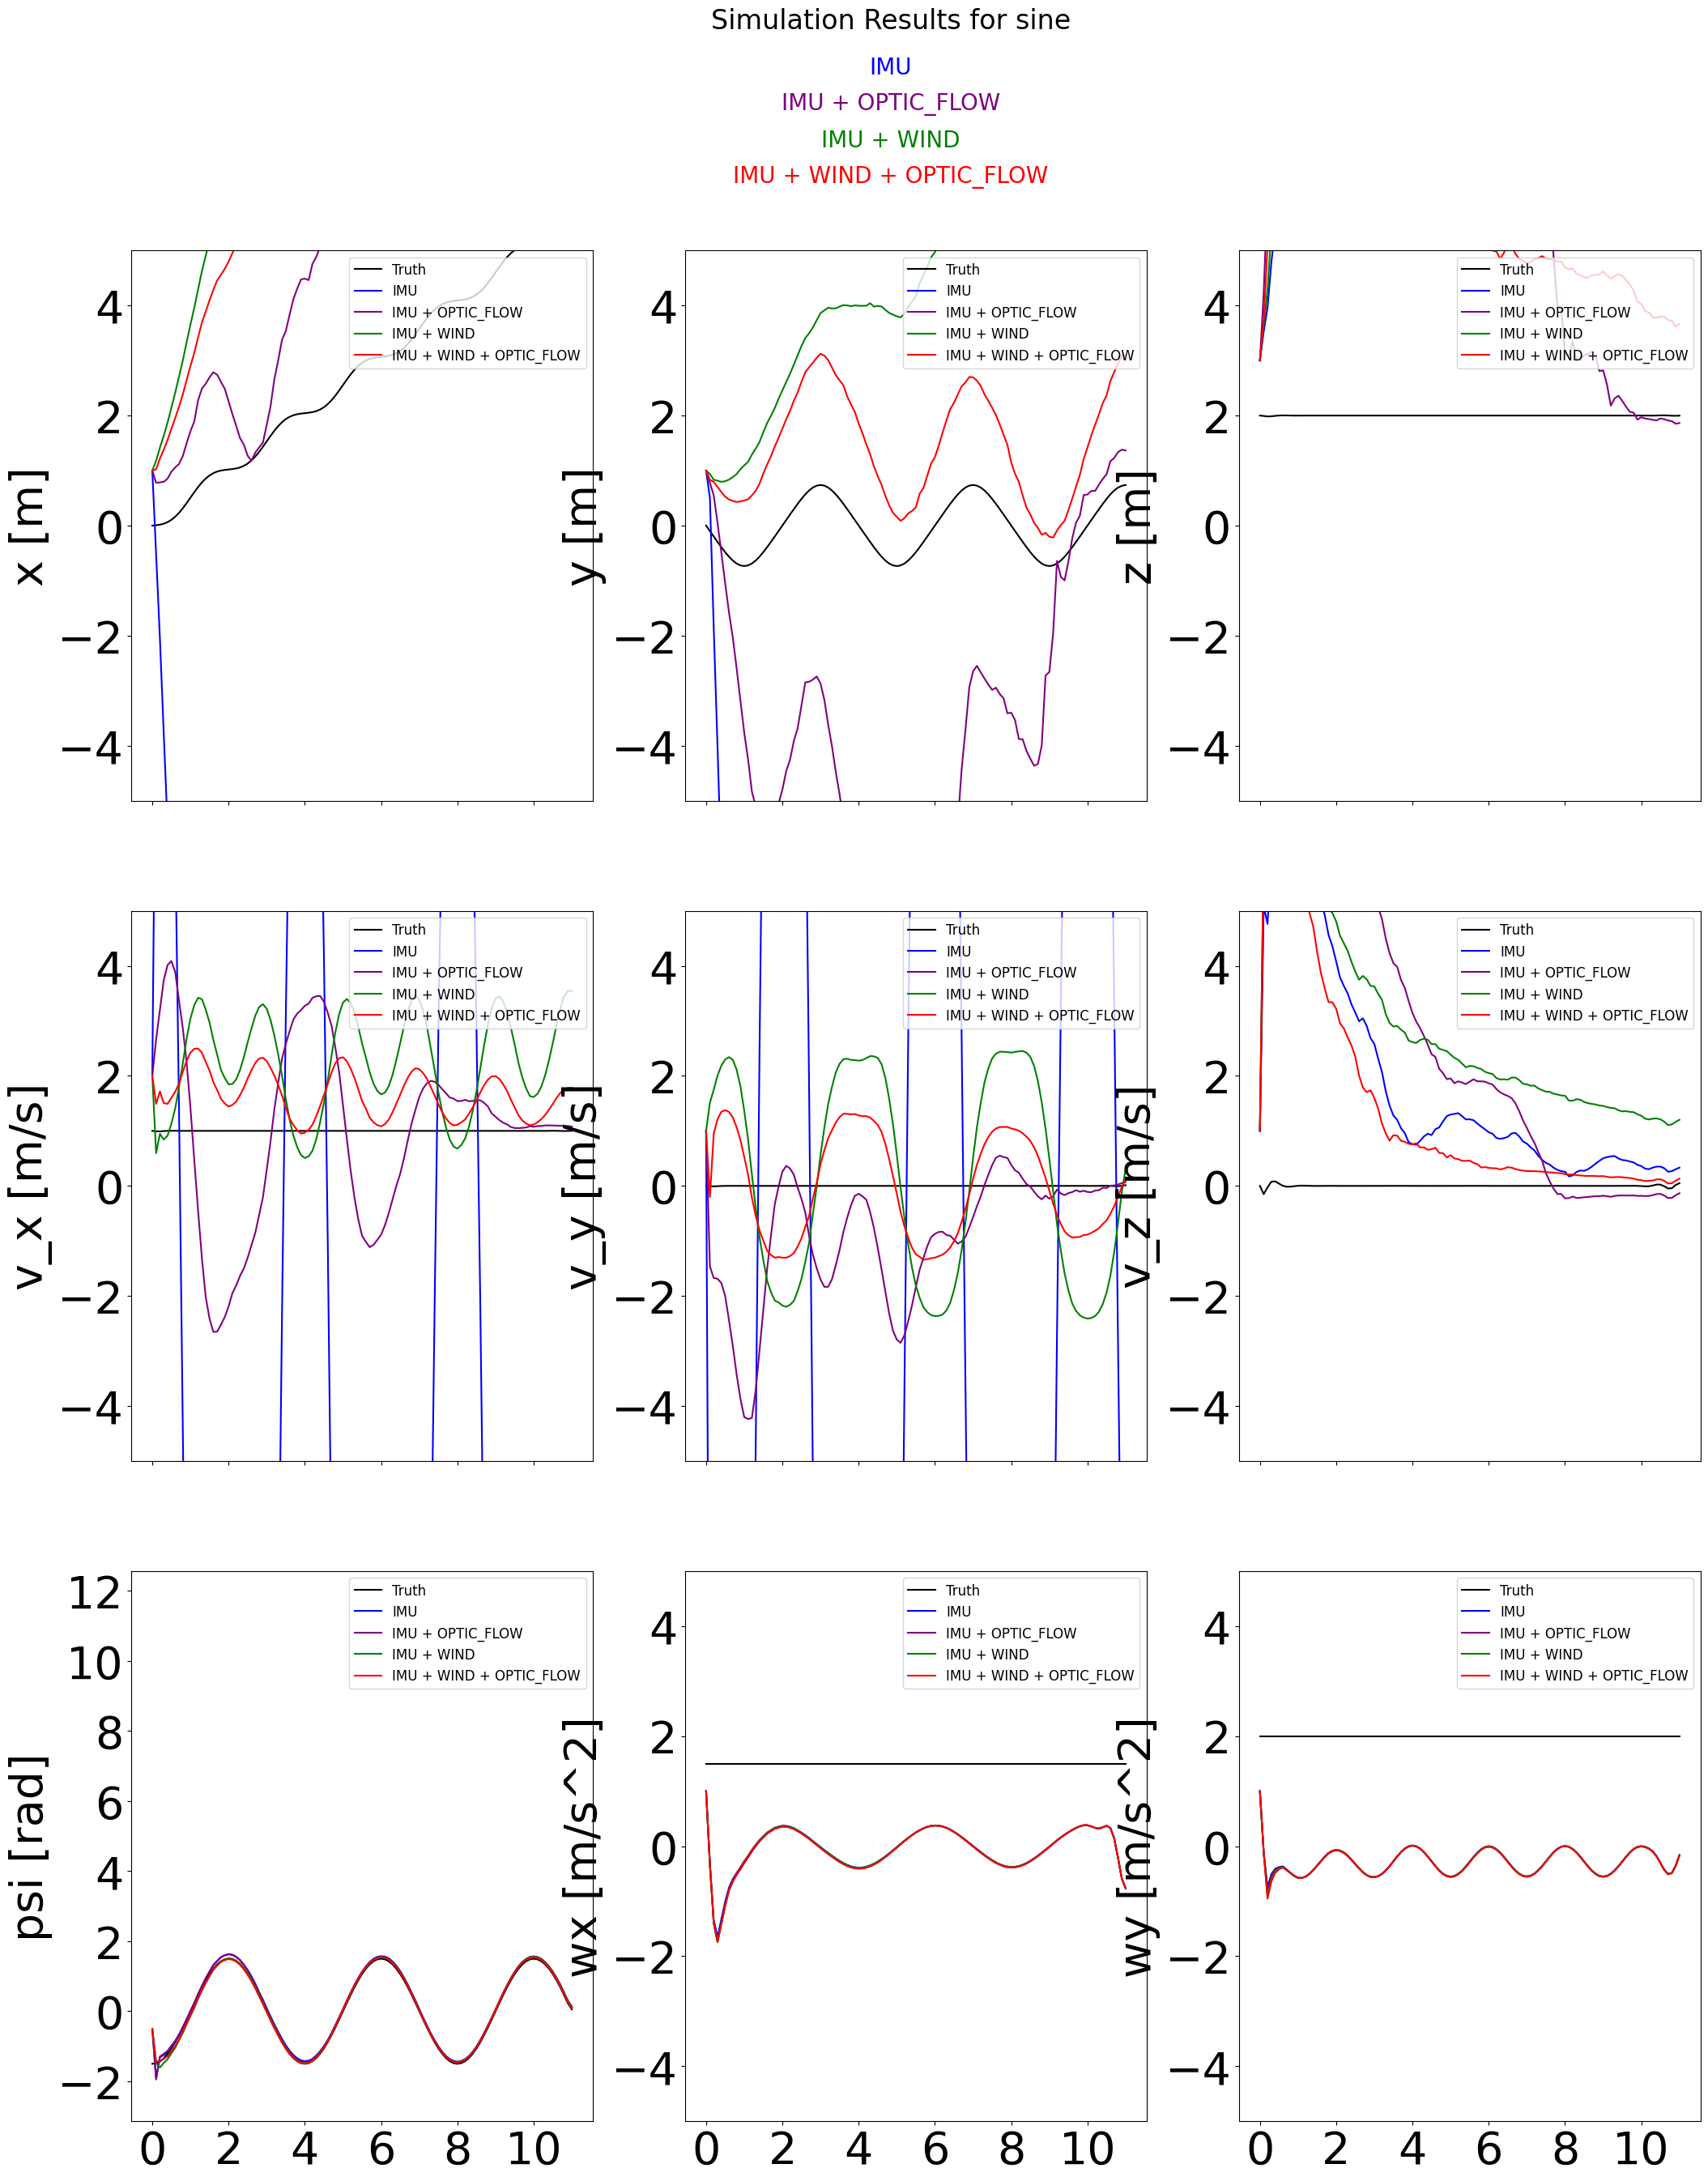

In [30]:
# creat a list of colors for each sensor combination
colors = {}
for sensor in SENSORS:
    if sensor == 'IMU':
        colors[sensor] = 'blue'
    elif sensor == 'IMU + OPTIC_FLOW':
        colors[sensor] = 'purple'
    elif sensor == 'IMU + WIND':
        colors[sensor] = 'green'
    elif sensor == 'IMU + WIND + OPTIC_FLOW':
        colors[sensor] = 'red'
    elif sensor == 'IMU + VEL + WIND':
        colors[sensor] = 'orange'
    else:
        raise ValueError('Invalid sensor type')
if Y_SWEEP == 'ALL':
    print('Plotting results for all sensors...')
    fig, ax = plt.subplots(3, 3, figsize=(25, 30), sharex=True)
    # set text size
    mpl.rcParams['font.size'] = 10
    # add figure title
    fig.suptitle(f'Simulation Results for {motif_type}', fontsize=24)

    # Add colored sensor names at the top, each on a new line
    sensor_labels = [
        ('IMU', colors['IMU']),
        ('IMU + OPTIC_FLOW', colors['IMU + OPTIC_FLOW']),
        ('IMU + WIND', colors['IMU + WIND']),
        ('IMU + WIND + OPTIC_FLOW', colors['IMU + WIND + OPTIC_FLOW'])
    ]
    for i, (label, color) in enumerate(sensor_labels):
        fig.text(
            0.5, 0.96 - i*0.015,  # y-position decreases for each sensor
            label,
            ha='center', va='top',
            fontsize=20,
            color=color
        )


    ax[0, 0].plot(t_sim, x_sim['x'], label='x',color = 'k')
    ax[0, 1].plot(t_sim, x_sim['y'], label='y',color = 'k')
    ax[0, 2].plot(t_sim, x_sim['z'], label='z',color = 'k')
    ax[1, 0].plot(t_sim, x_sim['v_x'], label='v_x',color = 'k')
    ax[1, 1].plot(t_sim, x_sim['v_y'], label='v_y',color = 'k')
    ax[1, 2].plot(t_sim, x_sim['v_z'], label='v_z',color = 'k')
    ax[2, 0].plot(t_sim, x_sim['psi'], label='psi',color = 'k')
    ax[2, 1].plot(t_sim, x_sim['wx'], label='wx',color = 'k')
    ax[2, 2].plot(t_sim, x_sim['wy'], label='wy',color = 'k')
    # add truth to SENSORS at the start call it LEGENDS
    LEGENDS = ['Truth']+SENSORS
    for sensor in SENSORS:
        ax[0, 0].plot(t_sim, xhat_dict[sensor]['x_hat'], label='x_hat', color=colors[sensor])
        ax[0, 0].set_ylabel('x [m]')
        ax[0, 0].set_ylim([-5, 5])
        ax[0, 0].legend(LEGENDS, loc='upper right', fontsize=12)
        ax[0, 1].plot(t_sim, xhat_dict[sensor]['y_hat'], label='y_hat', color=colors[sensor])
        ax[0, 1].set_ylabel('y [m]')
        ax[0, 1].set_ylim([-5, 5])
        ax[0, 1].legend(LEGENDS, loc='upper right', fontsize=12)
        ax[0, 2].plot(t_sim, xhat_dict[sensor]['z_hat'], label='z_hat', color=colors[sensor])
        ax[0, 2].set_ylabel('z [m]')
        ax[0, 2].set_ylim([-5, 5])
        ax[0, 2].legend(LEGENDS, loc='upper right', fontsize=12)
        ax[1, 0].plot(t_sim, xhat_dict[sensor]['v_x_hat'], label='v_x_hat', color=colors[sensor])
        ax[1, 0].set_ylabel('v_x [m/s]')
        ax[1, 0].set_ylim([-5, 5])
        ax[1, 0].legend(LEGENDS, loc='upper right', fontsize=12)
        ax[1, 1].plot(t_sim, xhat_dict[sensor]['v_y_hat'], label='v_y_hat', color=colors[sensor])
        ax[1, 1].set_ylabel('v_y [m/s]')
        ax[1, 1].set_ylim([-5, 5])
        ax[1, 1].legend(LEGENDS, loc='upper right', fontsize=12)
        ax[1, 2].plot(t_sim, xhat_dict[sensor]['v_z_hat'], label='v_z_hat', color=colors[sensor])
        ax[1, 2].set_ylabel('v_z [m/s]')
        ax[1, 2].set_ylim([-5, 5])
        ax[1, 2].legend(LEGENDS, loc='upper right', fontsize=12)
        ax[2, 0].plot(t_sim, xhat_dict[sensor]['psi_hat'], label='psi_hat', color=colors[sensor])
        ax[2, 0].set_ylabel('psi [rad]')
        ax[2, 0].set_ylim([-1*np.pi, 4*np.pi])
        ax[2, 0].legend(LEGENDS, loc='upper right', fontsize=12)
        ax[2, 1].plot(t_sim, xhat_dict[sensor]['wx_hat'], label='wx_hat', color=colors[sensor])
        ax[2, 1].set_ylabel('wx [m/s^2]')
        ax[2, 1].set_ylim([-5, 5])
        ax[2, 1].legend(LEGENDS, loc='upper right', fontsize=12)
        ax[2, 2].plot(t_sim, xhat_dict[sensor]['wy_hat'], label='wy_hat', color=colors[sensor])
        ax[2, 2].set_ylabel('wy [m/s^2]')
        ax[2, 2].set_ylim([-5, 5])
        ax[2, 2].legend(LEGENDS, loc='upper right', fontsize=12)
    # plt.tight_layout()
    plt.show()

else:
    fig, ax = plt.subplots(5, 3, figsize=(25, 30), sharex=True)
    # set text size
    mpl.rcParams['font.size'] = 18
    ax[0, 0].plot(t_sim, x_sim['x'], label='x',color = 'k')
    ax[0, 0].plot(t_sim, xhat_dict['x_hat'], label='x_hat', color = 'blue')
    ax[0, 0].set_ylabel('x [m]')
    ax[0, 0].set_ylim([-1, 15])
    ax[0, 1].plot(t_sim, x_sim['y'], label='y',color = 'k')
    ax[0, 1].plot(t_sim, xhat_dict['y_hat'], label='y_hat', color = 'blue')
    ax[0, 1].set_ylabel('y [m]')
    ax[0, 1].set_ylim([-1, 15])
    ax[0, 2].plot(t_sim, x_sim['z'], label='z',color = 'k')
    ax[0, 2].plot(t_sim, xhat_dict['z_hat'], label='z_hat', color = 'blue')
    ax[0, 2].set_ylabel('z [m]')
    ax[0, 2].set_ylim([-1, 15])
    ax[1, 0].plot(t_sim, x_sim['v_x'], label='v_x',color = 'k')
    ax[1, 0].plot(t_sim, xhat_dict['v_x_hat'], label='v_x_hat', color = 'blue')
    ax[1, 0].set_ylabel('v_x [m/s]')
    ax[1, 0].set_ylim([-5, 5])
    ax[1, 1].plot(t_sim, x_sim['v_y'], label='v_y',color = 'k')
    ax[1, 1].plot(t_sim, xhat_dict['v_y_hat'], label='v_y_hat', color = 'blue')
    ax[1, 1].set_ylabel('v_y [m/s]')
    ax[1, 1].set_ylim([-5, 5])
    ax[1, 2].plot(t_sim, x_sim['v_z'], label='v_z',color = 'k')
    ax[1, 2].plot(t_sim, xhat_dict['v_z_hat'], label='v_z_hat', color = 'blue')
    ax[1, 2].set_ylabel('v_z [m/s]')
    ax[1, 2].set_ylim([-5, 5])
    ax[2, 0].plot(t_sim, x_sim['psi'], label='psi',color = 'k')
    ax[2, 0].plot(t_sim, xhat_dict['psi_hat'], label='psi_hat', color = 'blue')
    ax[2, 0].set_ylabel('psi [rad]')
    ax[2, 0].set_ylim([-1*np.pi, 4*np.pi])
    ax[2, 1].plot(t_sim, x_sim['theta'], label='theta',color = 'k')
    ax[2, 1].plot(t_sim, xhat_dict['theta_hat'], label='theta_hat', color = 'blue')
    ax[2, 1].set_ylabel('theta [rad]')
    ax[2, 1].set_ylim([-1*np.pi, 4*np.pi])
    ax[2, 2].plot(t_sim, x_sim['phi'], label='phi',color = 'k')
    ax[2, 2].plot(t_sim, xhat_dict['phi_hat'], label='phi_hat', color = 'blue')
    ax[2, 2].set_ylabel('phi [rad]')
    ax[2, 2].set_ylim([-1*np.pi, 4*np.pi])
    ax[3, 0].plot(t_sim, x_sim['omega_x'], label='omega_x',color = 'k')
    ax[3, 0].plot(t_sim, xhat_dict['omega_x_hat'], label='omega_x_hat', color = 'blue')
    ax[3, 0].set_ylabel('omega_x [rad/s]')
    ax[3, 0].set_ylim([-5, 5])
    ax[3, 1].plot(t_sim, x_sim['omega_y'], label='omega_y',color = 'k')
    ax[3, 1].plot(t_sim, xhat_dict['omega_y_hat'], label='omega_y_hat', color = 'blue')
    ax[3, 1].set_ylabel('omega_y [rad/s]')
    ax[3, 1].set_ylim([-5, 5])
    ax[3, 2].plot(t_sim, x_sim['omega_z'], label='omega_z',color = 'k')
    ax[3, 2].plot(t_sim, xhat_dict['omega_z_hat'], label='omega_z_hat', color = 'blue')
    ax[3, 2].set_ylabel('omega_z [rad/s]')
    ax[3, 2].set_ylim([-5, 5])
    ax[4, 0].plot(t_sim, x_sim['wx'], label='wx',color = 'k')
    ax[4, 0].plot(t_sim, xhat_dict['wx_hat'], label='wx_hat', color = 'blue')
    ax[4, 0].set_ylabel('wx [m/s]')
    ax[4, 0].set_ylim([-5, 5])
    ax[4, 1].plot(t_sim, x_sim['wy'], label='wy',color = 'k')
    ax[4, 1].plot(t_sim, xhat_dict['wy_hat'], label='wy_hat', color = 'blue')
    ax[4, 1].set_ylabel('wy [m/s]')
    ax[4, 1].set_ylim([-5, 5])
    ax[4, 2].set_visible(False)  # Hide the empty subplot
    plt.xlabel('Time [s]')
    plt.title('EKF Results for trajectory type: ' + motif_type)
    plt.tight_layout()
    plt.show()

In [31]:
# # creat a list of colors for each sensor combination
# colors = {}
# for sensor in SENSORS:
#     if sensor == 'IMU':
#         colors[sensor] = 'blue'
#     elif sensor == 'IMU + OPTIC_FLOW':
#         colors[sensor] = 'purple'
#     elif sensor == 'IMU + WIND':
#         colors[sensor] = 'green'
#     elif sensor == 'IMU + WIND + OPTIC_FLOW':
#         colors[sensor] = 'red'
#     elif sensor == 'IMU + VEL + WIND':
#         colors[sensor] = 'orange'
#     else:
#         raise ValueError('Invalid sensor type')
# if Y_SWEEP == 'ALL':
#     print('Plotting results for all sensors...')
#     fig, ax = plt.subplots(4, 3, figsize=(25, 30), sharex=True)
#     # set text size
#     mpl.rcParams['font.size'] = 10
#     # add figure title
#     fig.suptitle(f'Simulation Results for {motif_type}', fontsize=24)

#     # Add colored sensor names at the top, each on a new line
#     sensor_labels = [
#         ('IMU', colors['IMU']),
#         ('IMU + OPTIC_FLOW', colors['IMU + OPTIC_FLOW']),
#         ('IMU + WIND', colors['IMU + WIND']),
#         ('IMU + WIND + OPTIC_FLOW', colors['IMU + WIND + OPTIC_FLOW'])
#     ]
#     for i, (label, color) in enumerate(sensor_labels):
#         fig.text(
#             0.5, 0.96 - i*0.015,  # y-position decreases for each sensor
#             label,
#             ha='center', va='top',
#             fontsize=20,
#             color=color
#         )


#     ax[0, 0].plot(t_sim, x_sim['x'], label='x',color = 'k')
#     ax[0, 1].plot(t_sim, x_sim['y'], label='y',color = 'k')
#     ax[0, 2].plot(t_sim, x_sim['z'], label='z',color = 'k')
#     ax[1, 0].plot(t_sim, x_sim['v_x'], label='v_x',color = 'k')
#     ax[1, 1].plot(t_sim, x_sim['v_y'], label='v_y',color = 'k')
#     ax[1, 2].plot(t_sim, x_sim['v_z'], label='v_z',color = 'k')
#     ax[2, 0].plot(t_sim, x_sim['phi'], label='phi',color = 'k')
#     ax[2, 1].plot(t_sim, x_sim['theta'], label='theta',color = 'k')
#     ax[2, 2].plot(t_sim, x_sim['psi'], label='psi',color = 'k')
#     ax[3, 0].plot(t_sim, x_sim['wx'], label='wx',color = 'k')
#     ax[3, 1].plot(t_sim, x_sim['wy'], label='wy',color = 'k')
#     # add truth to SENSORS at the start call it LEGENDS
#     LEGENDS = ['Truth']+SENSORS
#     for sensor in SENSORS:
#         ax[0, 0].plot(t_sim, xhat_dict[sensor]['x_hat'], label='x_hat', color=colors[sensor])
#         ax[0, 0].set_ylabel('x [m]')
#         ax[0, 0].set_ylim([-5, 5])
#         ax[0, 0].legend(LEGENDS, loc='upper right', fontsize=12)
#         ax[0, 1].plot(t_sim, xhat_dict[sensor]['y_hat'], label='y_hat', color=colors[sensor])
#         ax[0, 1].set_ylabel('y [m]')
#         ax[0, 1].set_ylim([-5, 5])
#         ax[0, 1].legend(LEGENDS, loc='upper right', fontsize=12)
#         ax[0, 2].plot(t_sim, xhat_dict[sensor]['z_hat'], label='z_hat', color=colors[sensor])
#         ax[0, 2].set_ylabel('z [m]')
#         ax[0, 2].set_ylim([-5, 5])
#         ax[0, 2].legend(LEGENDS, loc='upper right', fontsize=12)
#         ax[1, 0].plot(t_sim, xhat_dict[sensor]['v_x_hat'], label='v_x_hat', color=colors[sensor])
#         ax[1, 0].set_ylabel('v_x [m/s]')
#         ax[1, 0].set_ylim([-5, 5])
#         ax[1, 0].legend(LEGENDS, loc='upper right', fontsize=12)
#         ax[1, 1].plot(t_sim, xhat_dict[sensor]['v_y_hat'], label='v_y_hat', color=colors[sensor])
#         ax[1, 1].set_ylabel('v_y [m/s]')
#         ax[1, 1].set_ylim([-5, 5])
#         ax[1, 1].legend(LEGENDS, loc='upper right', fontsize=12)
#         ax[1, 2].plot(t_sim, xhat_dict[sensor]['v_z_hat'], label='v_z_hat', color=colors[sensor])
#         ax[1, 2].set_ylabel('v_z [m/s]')
#         ax[1, 2].set_ylim([-5, 5])
#         ax[1, 2].legend(LEGENDS, loc='upper right', fontsize=12)
#         ax[2, 0].plot(t_sim, xhat_dict[sensor]['phi_hat'], label='phi_hat', color=colors[sensor])
#         ax[2, 0].set_ylabel('phi [rad]')
#         ax[2, 0].set_ylim([-1*np.pi, 4*np.pi])
#         ax[2, 0].legend(LEGENDS, loc='upper right', fontsize=12)
#         ax[2, 1].plot(t_sim, xhat_dict[sensor]['theta_hat'], label='theta_hat', color=colors[sensor])
#         ax[2, 1].set_ylabel('theta [rad]')
#         ax[2, 1].set_ylim([-1*np.pi, 4*np.pi])
#         ax[2, 1].legend(LEGENDS, loc='upper right', fontsize=12)
#         ax[2, 2].plot(t_sim, xhat_dict[sensor]['psi_hat'], label='psi_hat', color=colors[sensor])
#         ax[2, 2].set_ylabel('psi [rad]')
#         ax[2, 2].set_ylim([-1*np.pi, 4*np.pi])
#         ax[2, 2].legend(LEGENDS, loc='upper right', fontsize=12)
#         ax[3, 0].plot(t_sim, xhat_dict[sensor]['wx_hat'], label='wx_hat', color=colors[sensor])
#         ax[3, 0].set_ylabel('wx [m/s^2]')
#         ax[3, 0].set_ylim([-5, 5])
#         ax[3, 0].legend(LEGENDS, loc='upper right', fontsize=12)
#         ax[3, 1].plot(t_sim, xhat_dict[sensor]['wy_hat'], label='wy_hat', color=colors[sensor])
#         ax[3, 1].set_ylabel('wy [m/s^2]')
#         ax[3, 1].set_ylim([-5, 5])
#         ax[3, 1].legend(LEGENDS, loc='upper right', fontsize=12)
#     # plt.tight_layout()
#     plt.show()

# else:
#     fig, ax = plt.subplots(5, 3, figsize=(25, 30), sharex=True)
#     # set text size
#     mpl.rcParams['font.size'] = 18
#     ax[0, 0].plot(t_sim, x_sim['x'], label='x',color = 'k')
#     ax[0, 0].plot(t_sim, xhat_dict['x_hat'], label='x_hat', color = 'blue')
#     ax[0, 0].set_ylabel('x [m]')
#     ax[0, 0].set_ylim([-1, 15])
#     ax[0, 1].plot(t_sim, x_sim['y'], label='y',color = 'k')
#     ax[0, 1].plot(t_sim, xhat_dict['y_hat'], label='y_hat', color = 'blue')
#     ax[0, 1].set_ylabel('y [m]')
#     ax[0, 1].set_ylim([-1, 15])
#     ax[0, 2].plot(t_sim, x_sim['z'], label='z',color = 'k')
#     ax[0, 2].plot(t_sim, xhat_dict['z_hat'], label='z_hat', color = 'blue')
#     ax[0, 2].set_ylabel('z [m]')
#     ax[0, 2].set_ylim([-1, 15])
#     ax[1, 0].plot(t_sim, x_sim['v_x'], label='v_x',color = 'k')
#     ax[1, 0].plot(t_sim, xhat_dict['v_x_hat'], label='v_x_hat', color = 'blue')
#     ax[1, 0].set_ylabel('v_x [m/s]')
#     ax[1, 0].set_ylim([-5, 5])
#     ax[1, 1].plot(t_sim, x_sim['v_y'], label='v_y',color = 'k')
#     ax[1, 1].plot(t_sim, xhat_dict['v_y_hat'], label='v_y_hat', color = 'blue')
#     ax[1, 1].set_ylabel('v_y [m/s]')
#     ax[1, 1].set_ylim([-5, 5])
#     ax[1, 2].plot(t_sim, x_sim['v_z'], label='v_z',color = 'k')
#     ax[1, 2].plot(t_sim, xhat_dict['v_z_hat'], label='v_z_hat', color = 'blue')
#     ax[1, 2].set_ylabel('v_z [m/s]')
#     ax[1, 2].set_ylim([-5, 5])
#     ax[2, 0].plot(t_sim, x_sim['psi'], label='psi',color = 'k')
#     ax[2, 0].plot(t_sim, xhat_dict['psi_hat'], label='psi_hat', color = 'blue')
#     ax[2, 0].set_ylabel('psi [rad]')
#     ax[2, 0].set_ylim([-1*np.pi, 4*np.pi])
#     ax[2, 1].plot(t_sim, x_sim['theta'], label='theta',color = 'k')
#     ax[2, 1].plot(t_sim, xhat_dict['theta_hat'], label='theta_hat', color = 'blue')
#     ax[2, 1].set_ylabel('theta [rad]')
#     ax[2, 1].set_ylim([-1*np.pi, 4*np.pi])
#     ax[2, 2].plot(t_sim, x_sim['phi'], label='phi',color = 'k')
#     ax[2, 2].plot(t_sim, xhat_dict['phi_hat'], label='phi_hat', color = 'blue')
#     ax[2, 2].set_ylabel('phi [rad]')
#     ax[2, 2].set_ylim([-1*np.pi, 4*np.pi])
#     ax[3, 0].plot(t_sim, x_sim['omega_x'], label='omega_x',color = 'k')
#     ax[3, 0].plot(t_sim, xhat_dict['omega_x_hat'], label='omega_x_hat', color = 'blue')
#     ax[3, 0].set_ylabel('omega_x [rad/s]')
#     ax[3, 0].set_ylim([-5, 5])
#     ax[3, 1].plot(t_sim, x_sim['omega_y'], label='omega_y',color = 'k')
#     ax[3, 1].plot(t_sim, xhat_dict['omega_y_hat'], label='omega_y_hat', color = 'blue')
#     ax[3, 1].set_ylabel('omega_y [rad/s]')
#     ax[3, 1].set_ylim([-5, 5])
#     ax[3, 2].plot(t_sim, x_sim['omega_z'], label='omega_z',color = 'k')
#     ax[3, 2].plot(t_sim, xhat_dict['omega_z_hat'], label='omega_z_hat', color = 'blue')
#     ax[3, 2].set_ylabel('omega_z [rad/s]')
#     ax[3, 2].set_ylim([-5, 5])
#     ax[4, 0].plot(t_sim, x_sim['wx'], label='wx',color = 'k')
#     ax[4, 0].plot(t_sim, xhat_dict['wx_hat'], label='wx_hat', color = 'blue')
#     ax[4, 0].set_ylabel('wx [m/s]')
#     ax[4, 0].set_ylim([-5, 5])
#     ax[4, 1].plot(t_sim, x_sim['wy'], label='wy',color = 'k')
#     ax[4, 1].plot(t_sim, xhat_dict['wy_hat'], label='wy_hat', color = 'blue')
#     ax[4, 1].set_ylabel('wy [m/s]')
#     ax[4, 1].set_ylim([-5, 5])
#     ax[4, 2].set_visible(False)  # Hide the empty subplot
#     plt.xlabel('Time [s]')
#     plt.title('EKF Results for trajectory type: ' + motif_type)
#     plt.tight_layout()
#     plt.show()

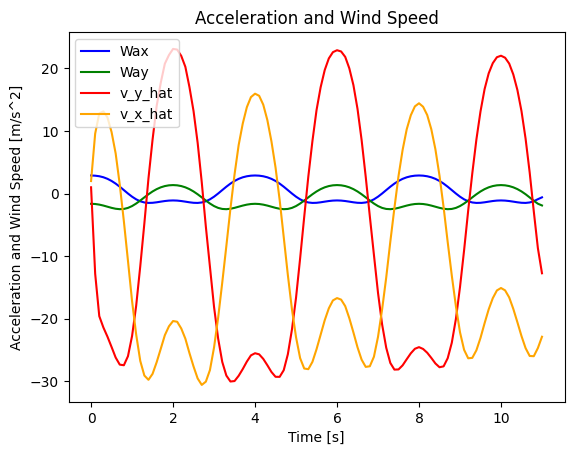

In [32]:
# plot acceleration and wind speed
plt.plot(t_sim, y_sim['Wax'], label='Wax', color='blue')
plt.plot(t_sim, y_sim['Way'], label='Way', color='green')
plt.plot(t_sim, xhat_dict['IMU']['v_y_hat'], label='v_y_hat', color='red')
plt.plot(t_sim, xhat_dict['IMU']['v_x_hat'], label='v_x_hat', color='orange')
plt.xlabel('Time [s]')
plt.ylabel('Acceleration and Wind Speed [m/s^2]')
plt.title('Acceleration and Wind Speed')
plt.legend()
plt.show()